In [1]:
import tensorflow as tf
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder,minmax_scale,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,log_loss, confusion_matrix,ConfusionMatrixDisplay
import IPython.display as ipd

## Using the Dataset via Kaggle API

In [2]:
!pip install -q kaggle


In [3]:
from google.colab import files
files.upload() # My kaggle key (json file) is hidden for privacy


Saving kaggle-5.json to kaggle-5.json


{'kaggle-5.json': b'{"username":"ray0911","key":"544b338e2b9670a6636557d698854e27"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle-5.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamhungundji/dysarthria-detection")

print("Path to dataset files:", path)

100%|██████████| 155M/155M [00:09<00:00, 16.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/iamhungundji/dysarthria-detection/versions/1


In [6]:
!cp -r /root/.cache/kagglehub/datasets/iamhungundji/dysarthria-detection/versions/1 /content/


In [7]:
import os

directory_path = "/content/1/torgo_data"

# List all files and directories inside
df = os.listdir(directory_path)

# Print the contents
print(df)


['non_dysarthria_male', 'dysarthria_female', 'non_dysarthria_female', 'dysarthria_male', 'data.csv']


In [8]:
import pandas as pd
import os

# Define the file path
csv_path = "/content/1/torgo_data/data.csv"

# Check if the file exists
if os.path.exists(csv_path):
    # Read the CSV file
    df = pd.read_csv(csv_path)

    # Display the first few rows
    print(df.head())  # Print first 5 rows
else:
    print("File 'data.csv' not found in the directory.")


    is_dysarthria  gender                                           filename
0  non_dysarthria  female  torgo_data/non_dysarthria_female/FC03_Session2...
1  non_dysarthria  female  torgo_data/non_dysarthria_female/FC02_Session3...
2  non_dysarthria  female  torgo_data/non_dysarthria_female/FC02_Session3...
3  non_dysarthria  female  torgo_data/non_dysarthria_female/FC03_Session2...
4  non_dysarthria  female  torgo_data/non_dysarthria_female/FC03_Session1...


## Fixing the File Paths

In [9]:
for col in df.columns:
    unique_values = df[col].unique()
    print(f"Unique values in '{col}':\n{unique_values}\n")

Unique values in 'is_dysarthria':
['non_dysarthria' 'dysarthria']

Unique values in 'gender':
['female' 'male']

Unique values in 'filename':
['torgo_data/non_dysarthria_female/FC03_Session2_0146.wav'
 'torgo_data/non_dysarthria_female/FC02_Session3_0712.wav'
 'torgo_data/non_dysarthria_female/FC02_Session3_0679.wav' ...
 'torgo_data/dysarthria_male/M03_Session2_0040.wav'
 'torgo_data/dysarthria_male/M03_Session2_0260.wav'
 'torgo_data/dysarthria_male/M03_Session2_0145.wav']



In [10]:
import pandas as pd

# Load the CSV file
csv_path = "/content/1/torgo_data/data.csv"
df = pd.read_csv(csv_path)

# Modify the 'filename' column to include '/content/1/' at the front
df["filename"] = "/content/1/" + df["filename"]

# Save the updated CSV file
df.to_csv(csv_path, index=False)

print("CSV file updated successfully!")


CSV file updated successfully!


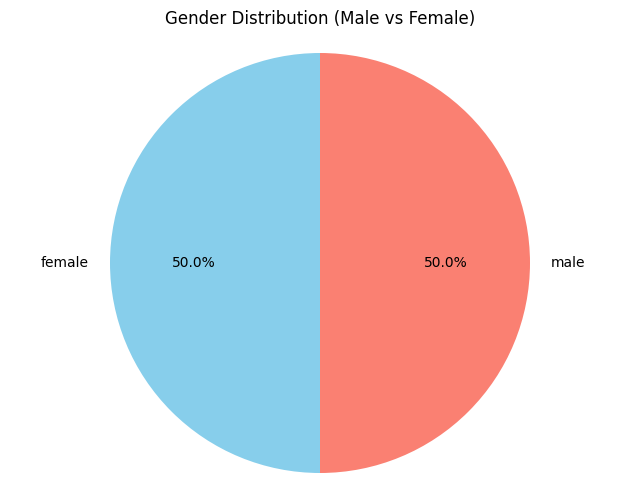

In [41]:
import matplotlib.pyplot as plt

# Plotting pie chart for Gender (Male vs Female)
gender_counts = df['gender'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Gender Distribution (Male vs Female)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

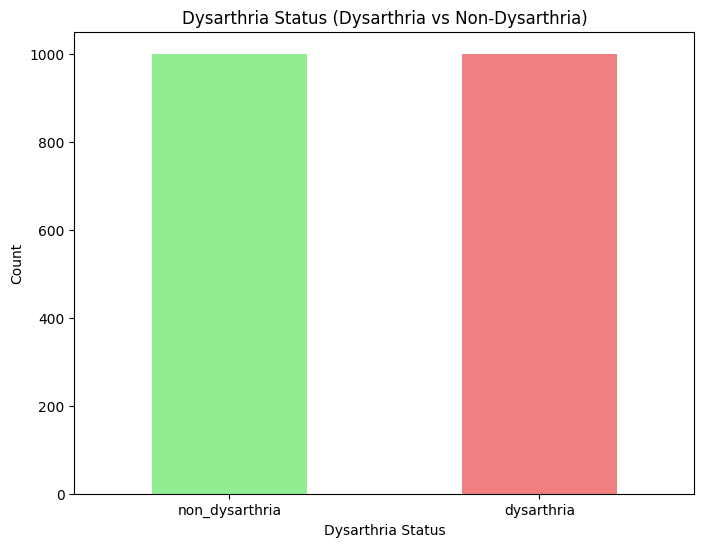

In [42]:
dysarthria_counts = df['is_dysarthria'].value_counts()

# Plotting the bar chart for Dysarthria vs Non-Dysarthria
plt.figure(figsize=(8, 6))
dysarthria_counts.plot(kind='bar', color=['lightgreen', 'lightcoral'])

# Adding title and labels
plt.title('Dysarthria Status (Dysarthria vs Non-Dysarthria)')
plt.xlabel('Dysarthria Status')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Makes sure the x-axis labels are horizontal

# Display the plot
plt.show()

The above shows that we have a biased dataset. Hence, no need for re-balancing

## Audio EDA

1. Waveplot - visual representation of a sound signal over time. It shows the amplitude (volume) of the sound at each moment in time.
2. Spectrogram -  2D plot that shows how the frequencies in a sound signal change over time. It combines both the time and frequency information.
3. Zero Crossing Rate - Measure how often the sound signal crosses the zero amplitude line (goes from positive to negative or vice versa) over time.
4. MFCCs (Mel Frequency Cepstral Coefficients) - Features used to represent the timbre (color or texture) of sound. They are based on how humans perceive pitch and frequency, designed to simulate the way our ears process sound.
5. Mel Spectrogram -  A scale of frequencies that is more aligned with how humans perceive pitch

In [43]:
def waveform(file,is_dysarthria,gender):
    x , sr = librosa.load(file)
    plt.figure(figsize=(20, 5))
    plt.title("Waveplot of " +is_dysarthria+' ' +gender )
    librosa.display.waveshow(x, sr=sr)
    plt.show

In [44]:
def Spectogram(file,is_dysarthria,gender):
    x, sr = librosa.load(file)

    plt.figure(figsize=(20, 5))
    plt.title("Specshow of " +is_dysarthria+' ' +gender )
    X = librosa.stft(x)

    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb,sr = sr, x_axis="time",y_axis = "log")
    plt.show()

In [45]:
def Zero_crossing_rate(file,is_dysarthria,gender):
    x, sr = librosa.load(file)

    zero_crossings = librosa.zero_crossings(x)
    print("Sum of zero crossing ", zero_crossings.sum())
    plt.figure(figsize=(20, 5))
    plt.title("Zero Crossing Rate of "  +is_dysarthria+' ' +gender )
    zcrs = librosa.feature.zero_crossing_rate(x)
    plt.plot(zcrs[0])
    plt.show()

In [46]:
def mfcc(file,is_dysarthria,gender):
    x,  sr = librosa.load(file)
    plt.figure(figsize=(20, 6))
    plt.title("MFCC Spectral of "  +is_dysarthria+' ' +gender )
    mfccs = librosa.feature.mfcc(y=x, sr=sr)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.show()

In [47]:

def mel_Spectogram(file,is_dysarthria,gender):
    x,  sr = librosa.load(file)
    plt.figure(figsize=(20, 6))
    plt.title("Mel Spectrogram of "  +is_dysarthria+ ' '+gender )
    mel_spec = librosa.feature.melspectrogram(y=x, sr=sr)
    librosa.display.specshow(mel_spec, sr=sr, x_axis='time')
    plt.show()

In [48]:
def get_feature_plot(file,is_dysarthria,gender):
    waveform(file,is_dysarthria,gender)
    Spectogram(file,is_dysarthria,gender)
    Zero_crossing_rate(file,is_dysarthria,gender)
    mel_Spectogram(file,is_dysarthria,gender)
    mfcc(file,is_dysarthria,gender)

def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

## EDA PLOTS

- Plots done for
- Female with no dysarthria
- Female with dysarthria
- Male with no dysarthria
- Male with dysarthria


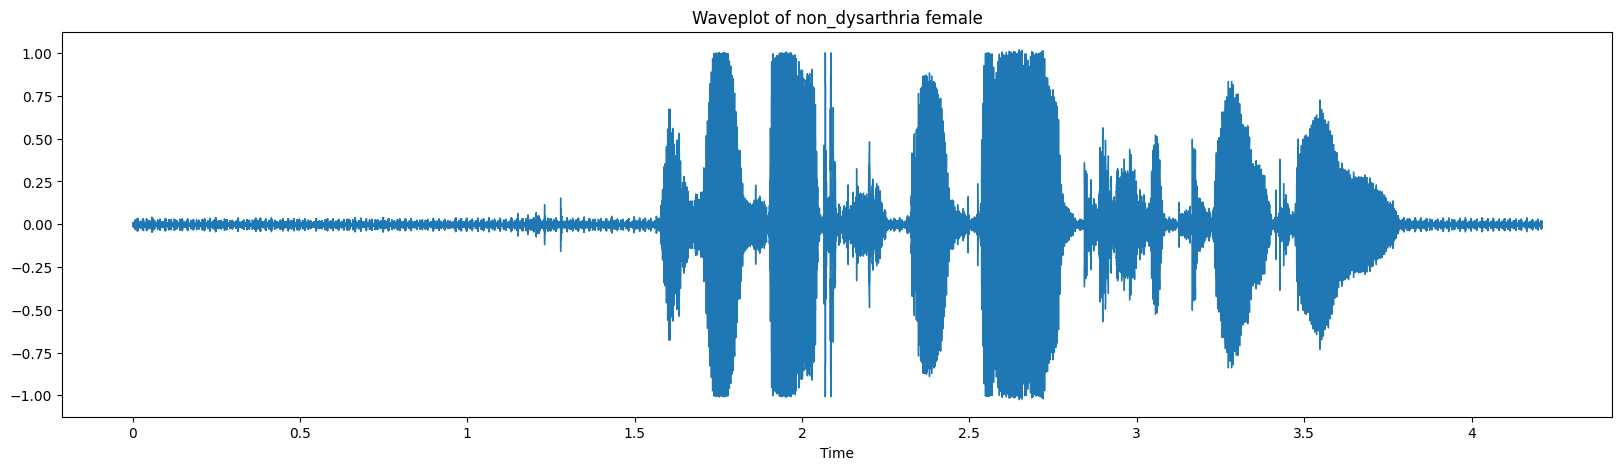

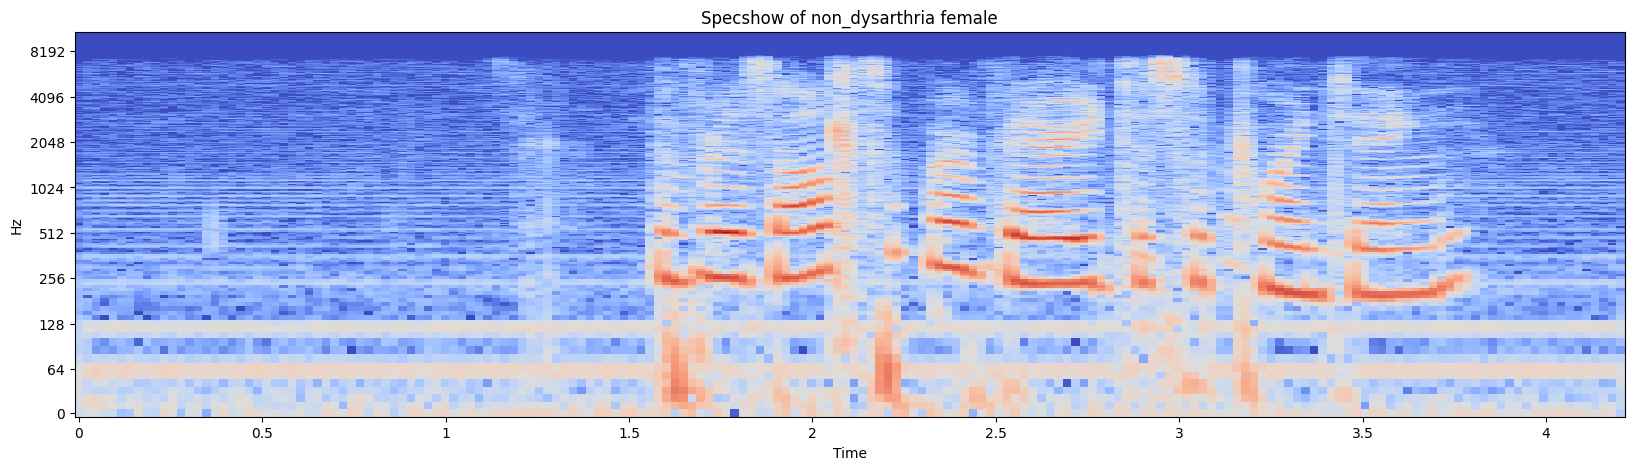

Sum of zero crossing  8748


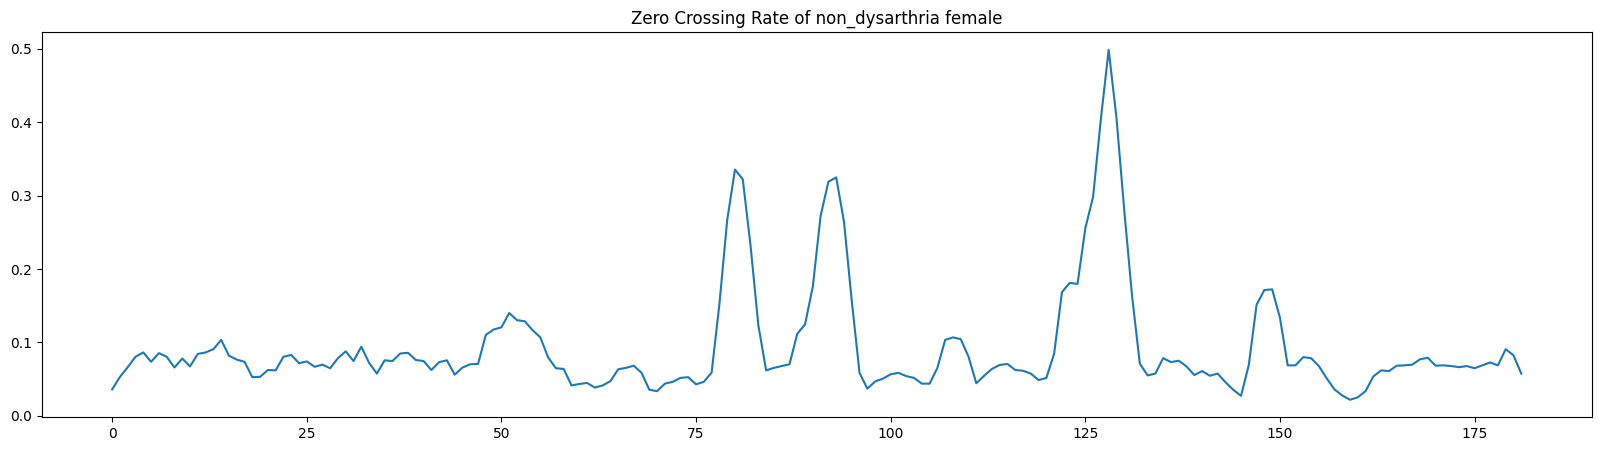

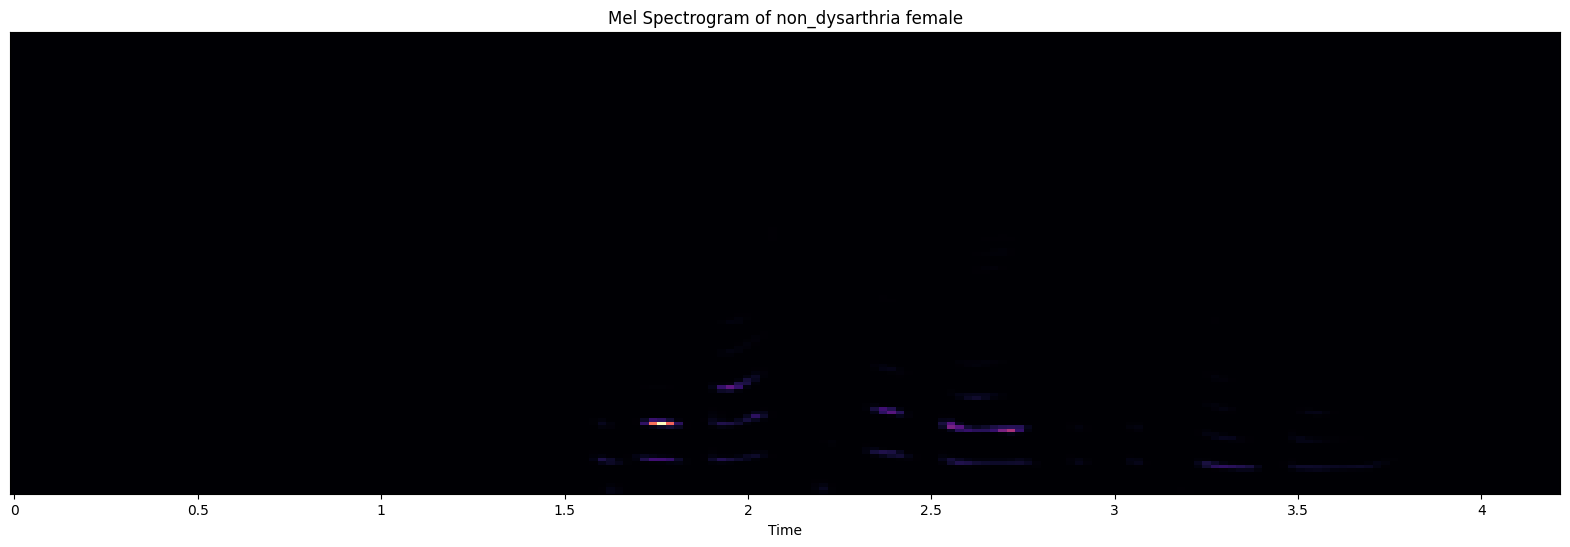

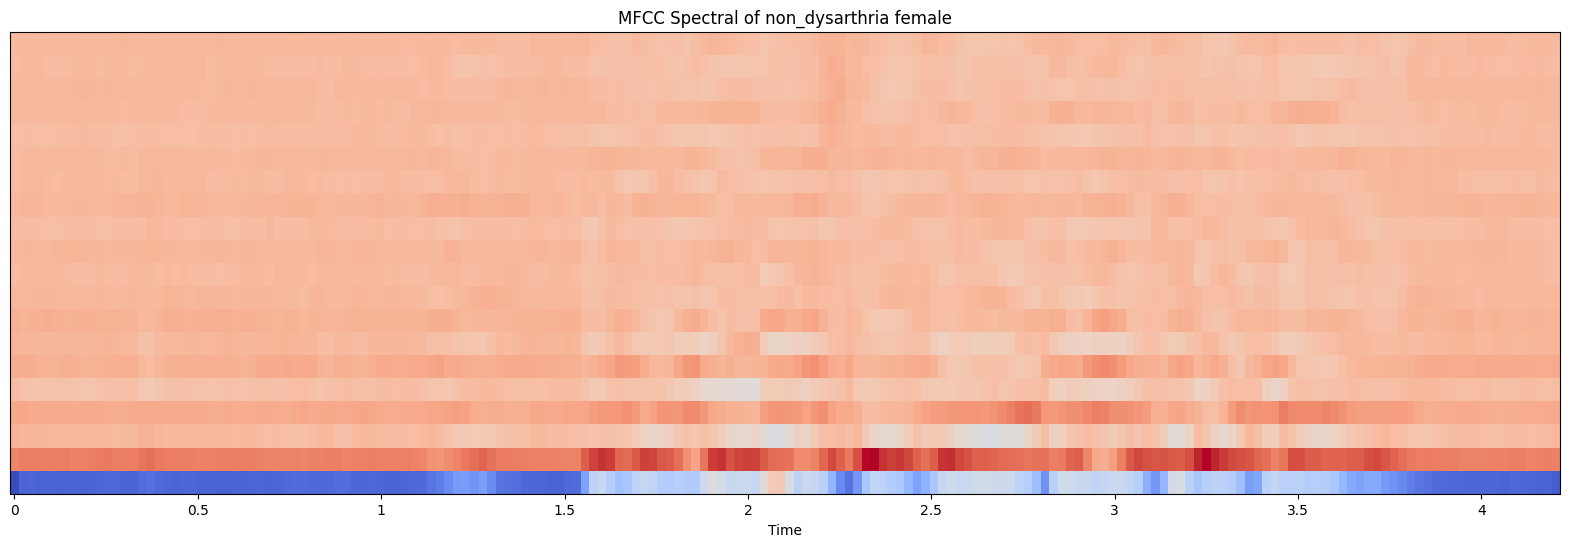

In [12]:
sample = df[(df["is_dysarthria"] == "non_dysarthria") & (df["gender"] == "female")]
get_feature_plot(sample['filename'].values[0], sample['is_dysarthria'].values[0], sample['gender'].values[0])
ipd.Audio(sample.filename.values[0])

## Female with Dysarthria


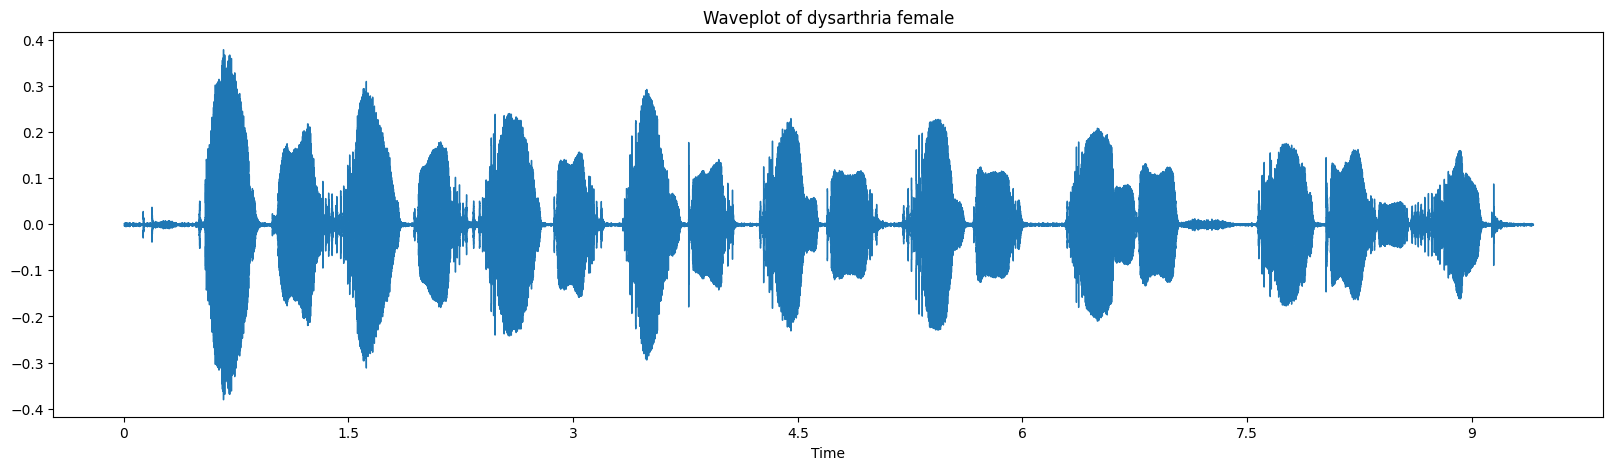

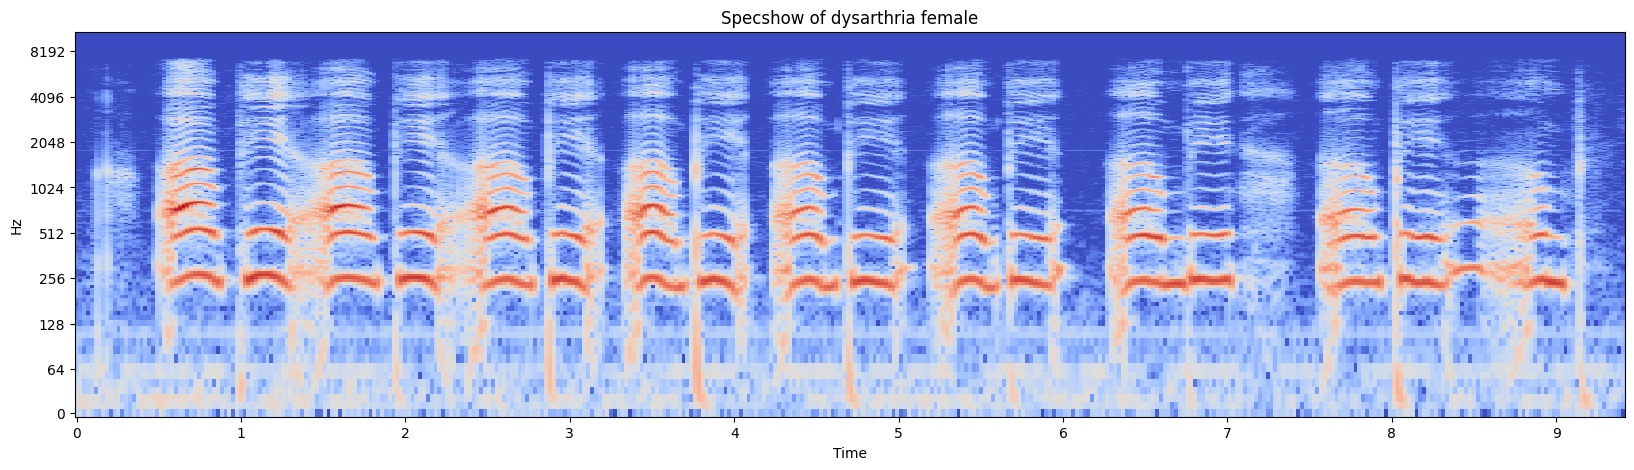

Sum of zero crossing  9225


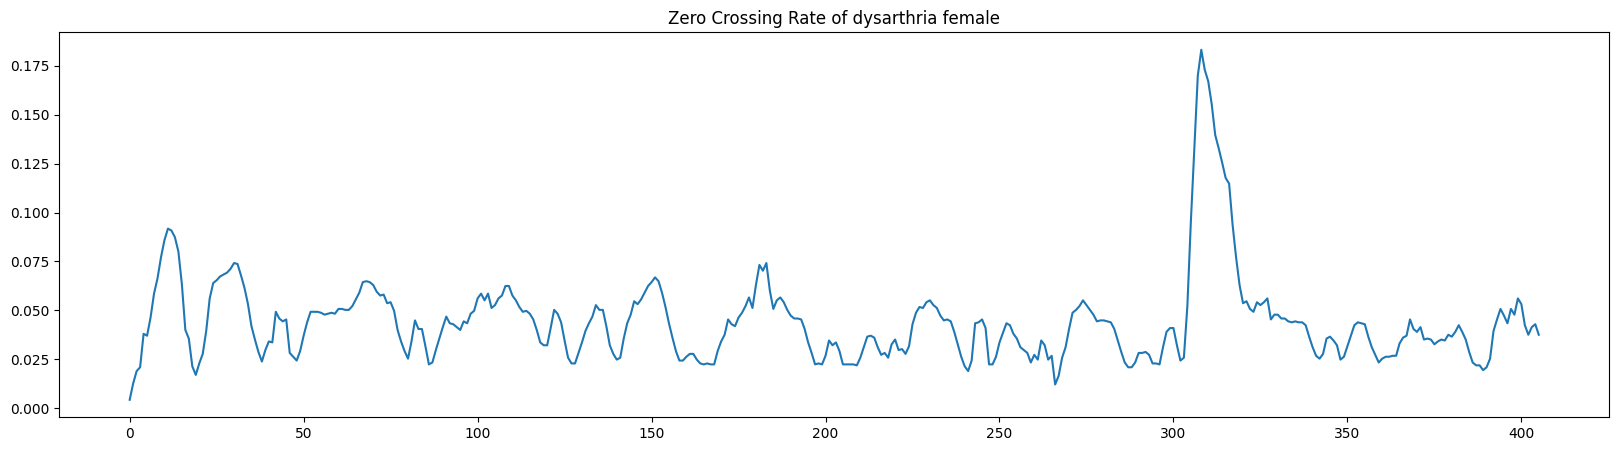

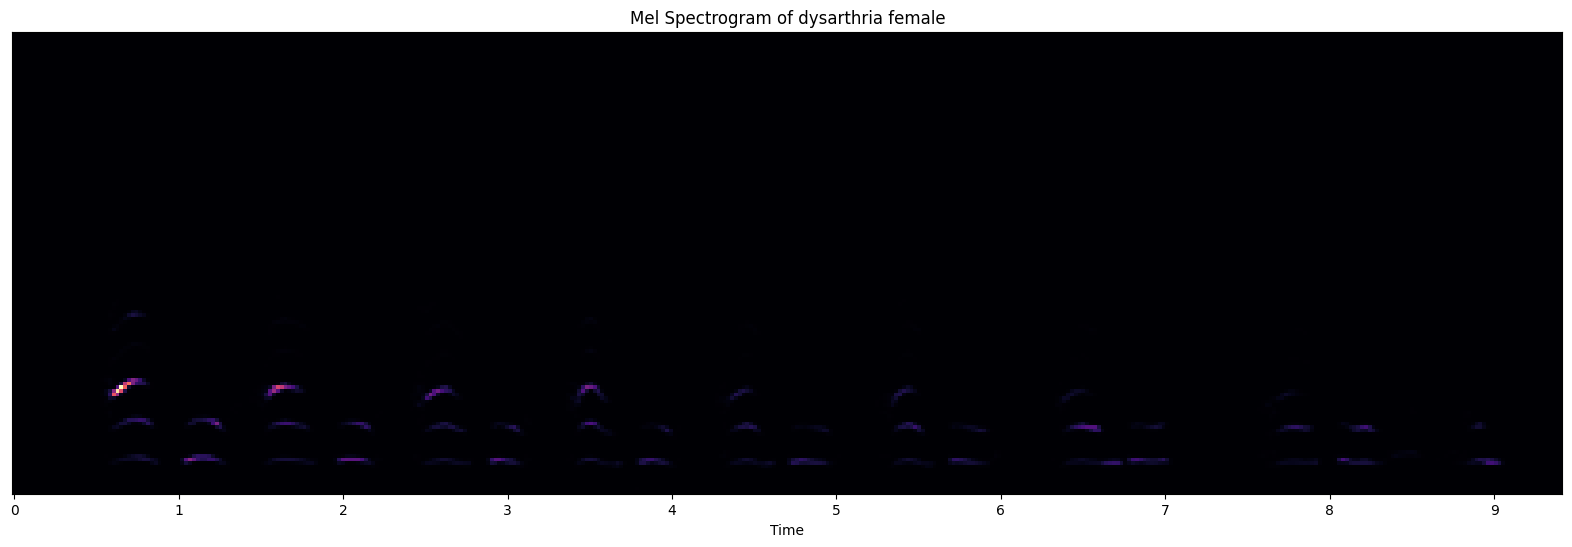

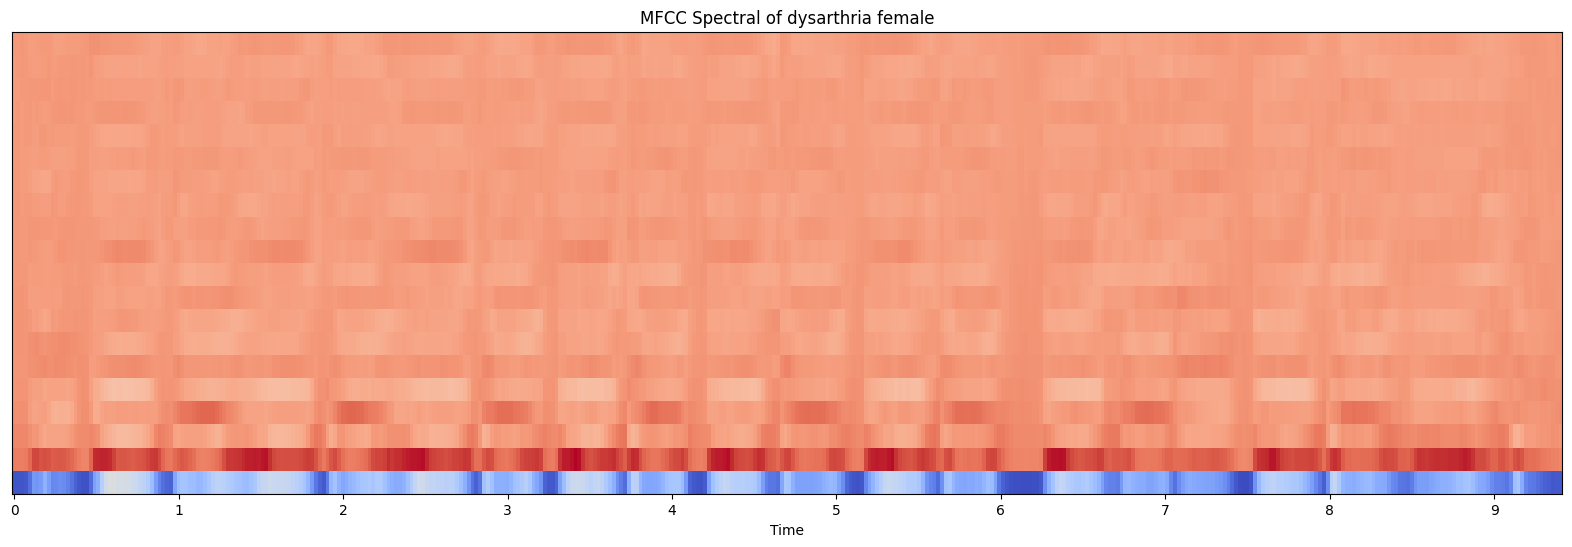

In [49]:
sample_female_dysarthria = df[(df["is_dysarthria"] == "dysarthria") & (df["gender"] == "female")]
get_feature_plot(sample_female_dysarthria['filename'].values[0],
                 sample_female_dysarthria['is_dysarthria'].values[0],
                 sample_female_dysarthria['gender'].values[0])
ipd.Audio(sample_female_dysarthria.filename.values[0])

## Male with Dysarthria

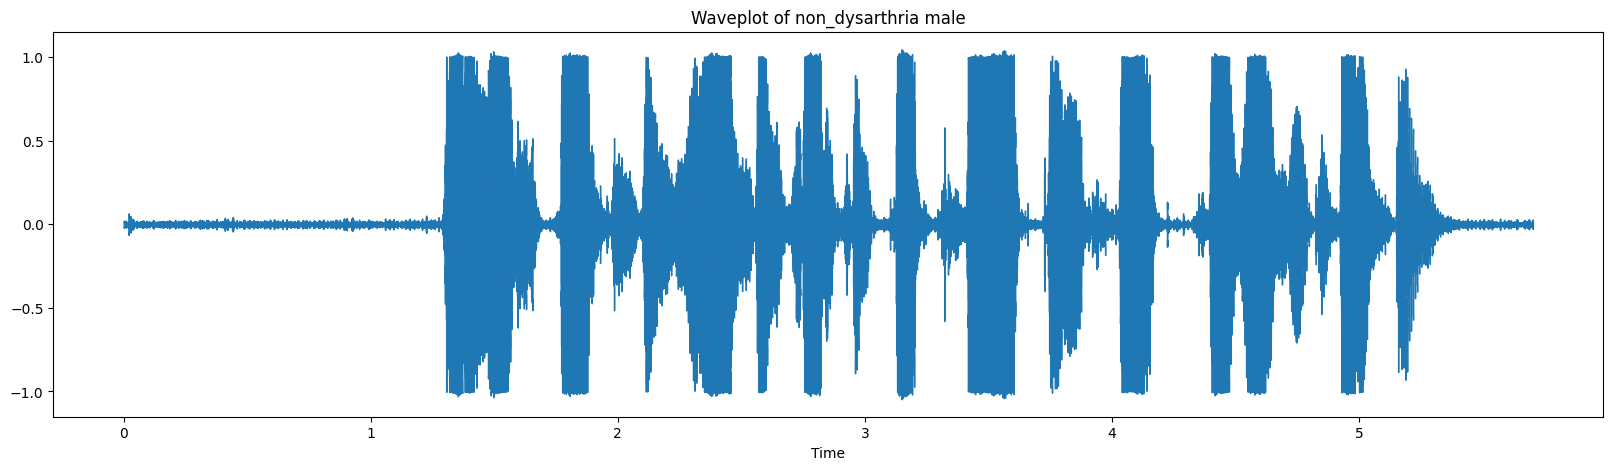

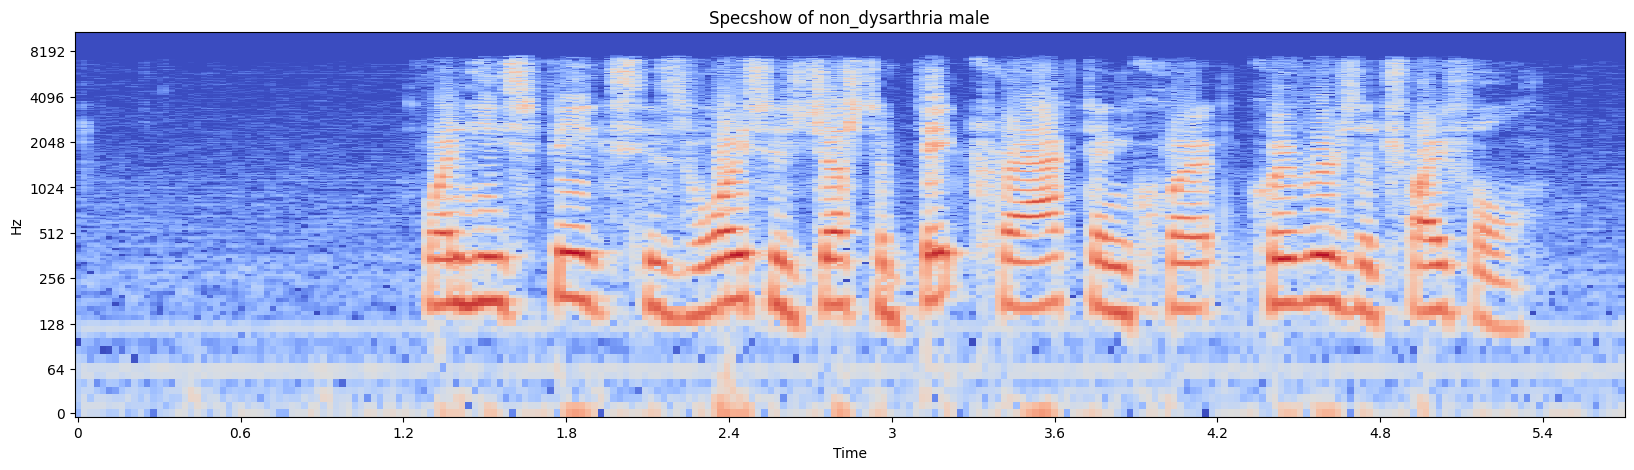

Sum of zero crossing  11700


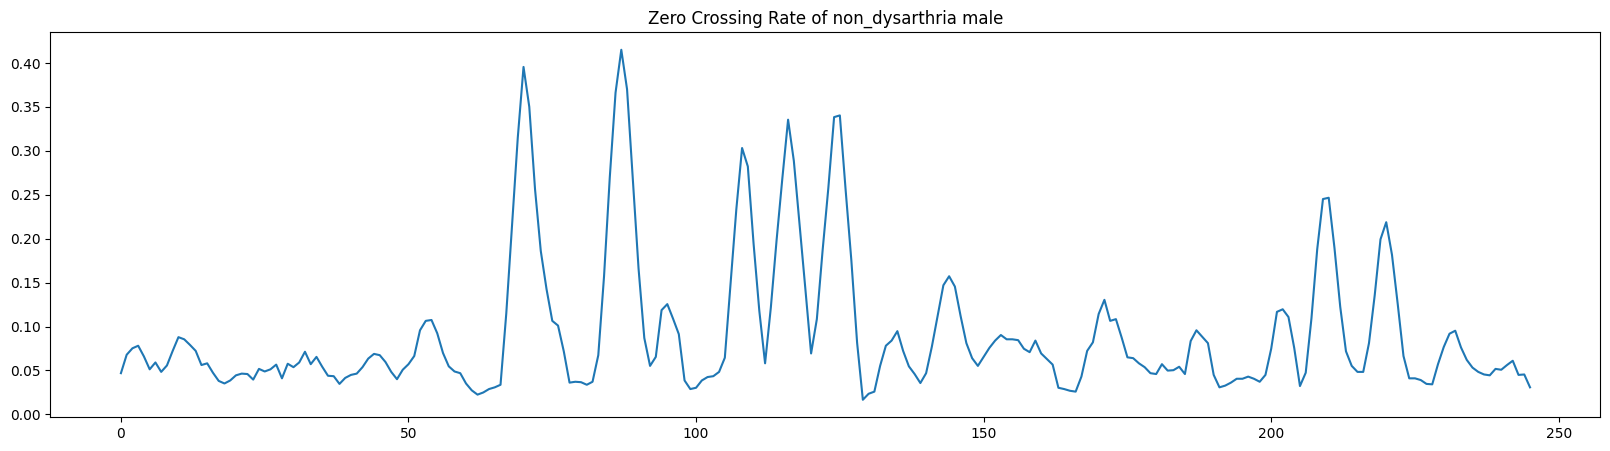

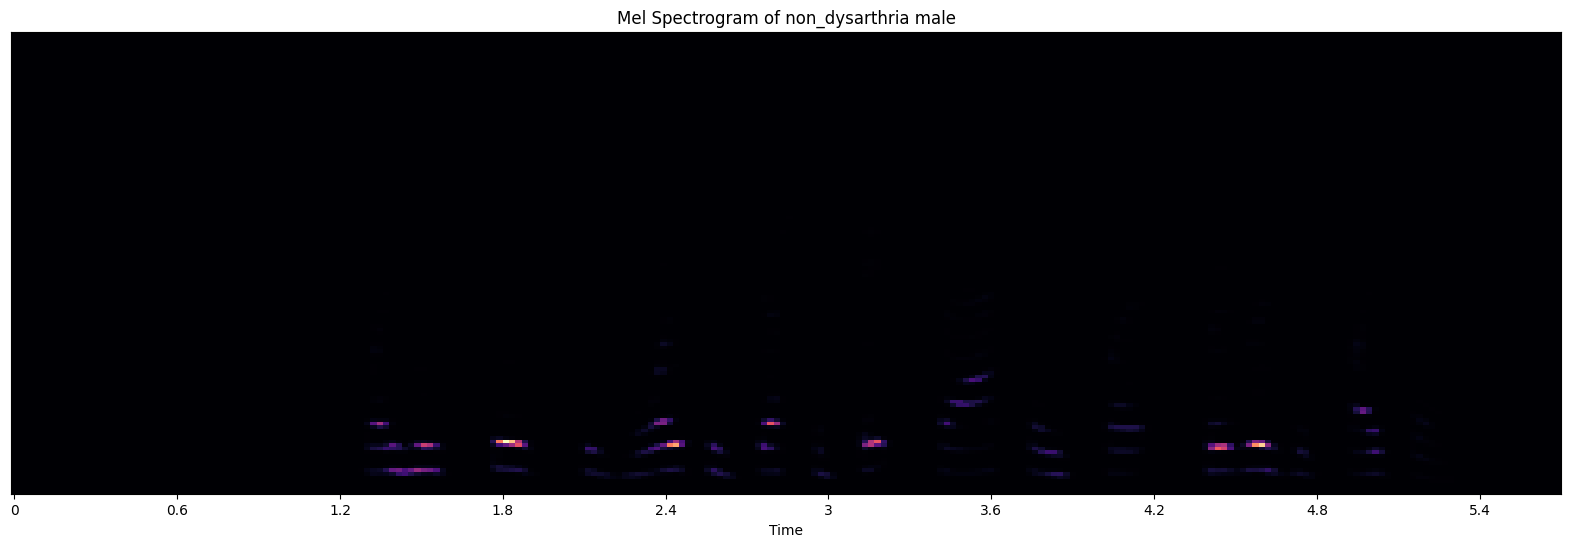

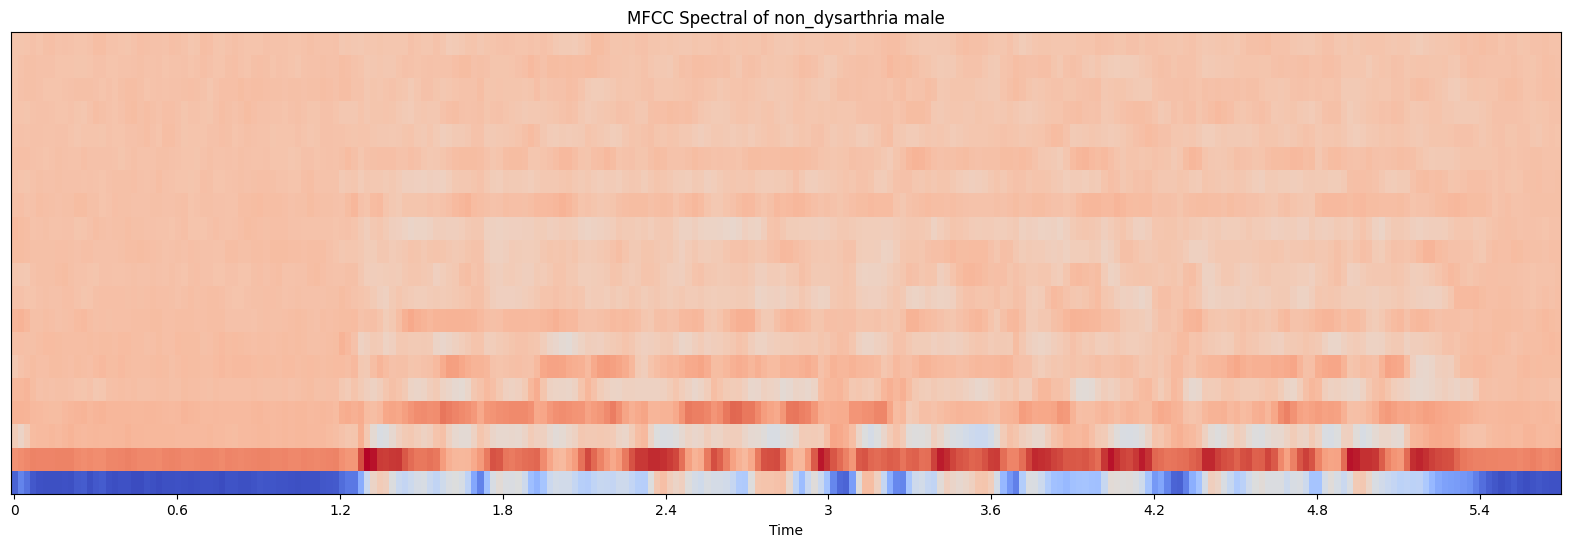

In [50]:
sample_male_non_dysarthria = df[(df["is_dysarthria"] == "non_dysarthria") & (df["gender"] == "male")]
get_feature_plot(sample_male_non_dysarthria['filename'].values[0],
                 sample_male_non_dysarthria['is_dysarthria'].values[0],
                 sample_male_non_dysarthria['gender'].values[0])
ipd.Audio(sample_male_non_dysarthria.filename.values[0])

## Male with Dysarthria

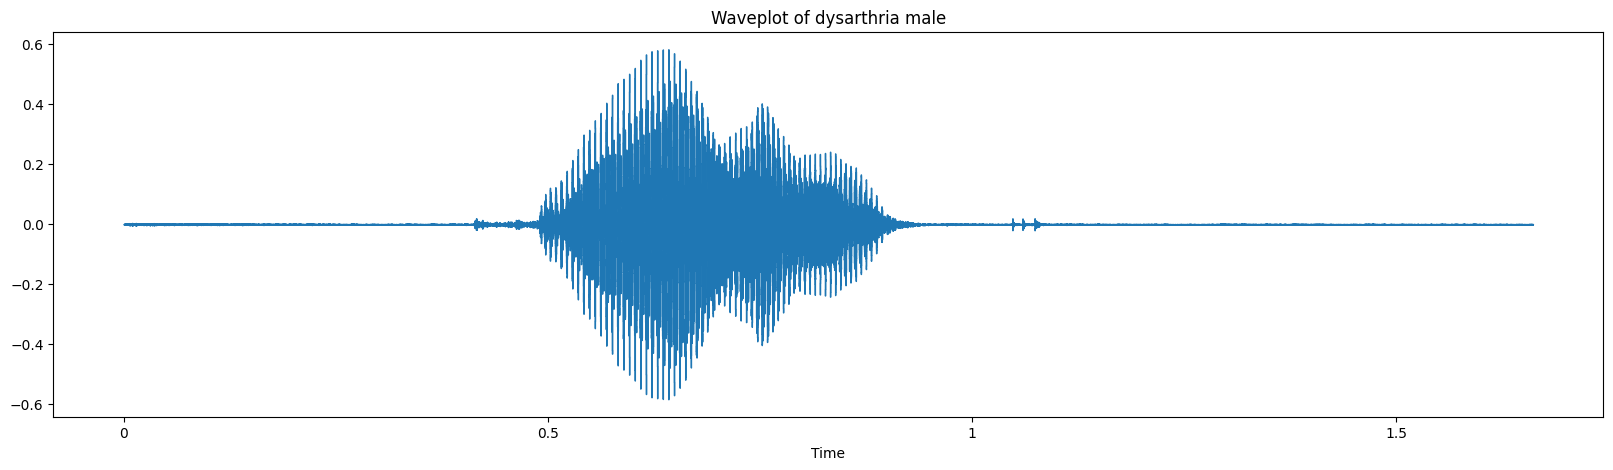

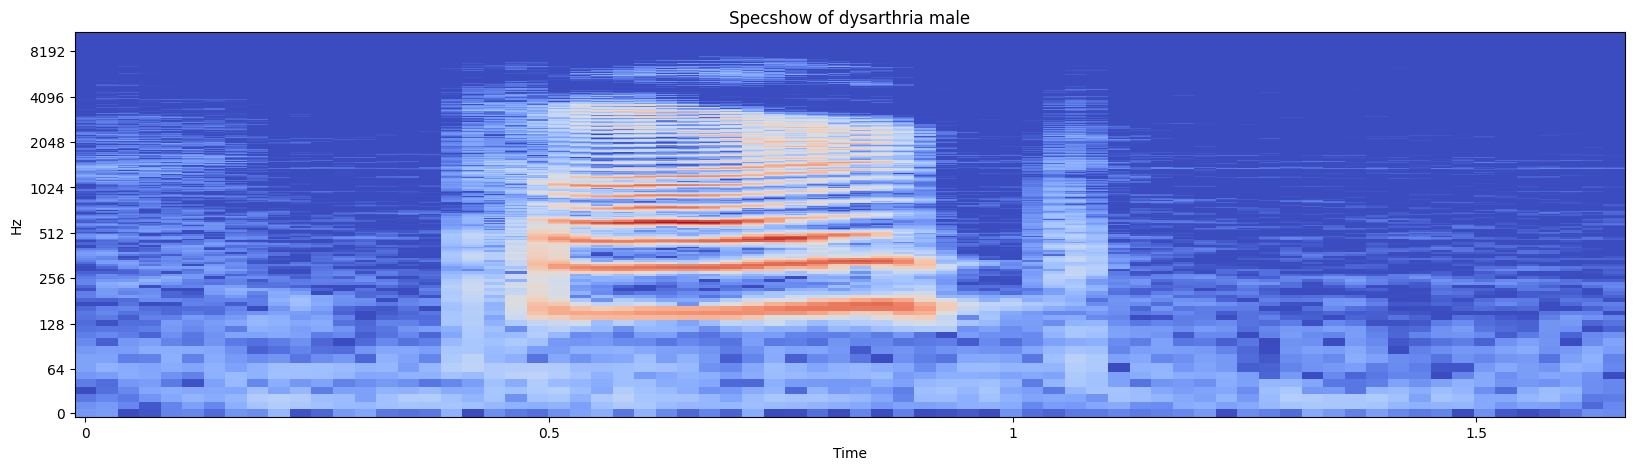

Sum of zero crossing  3219


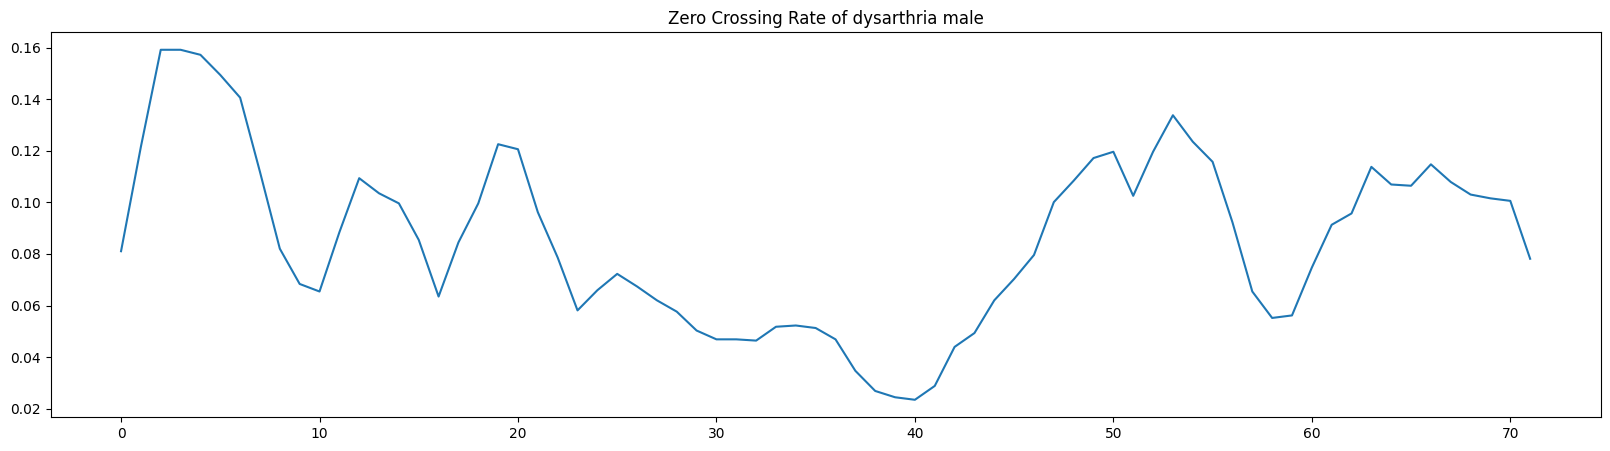

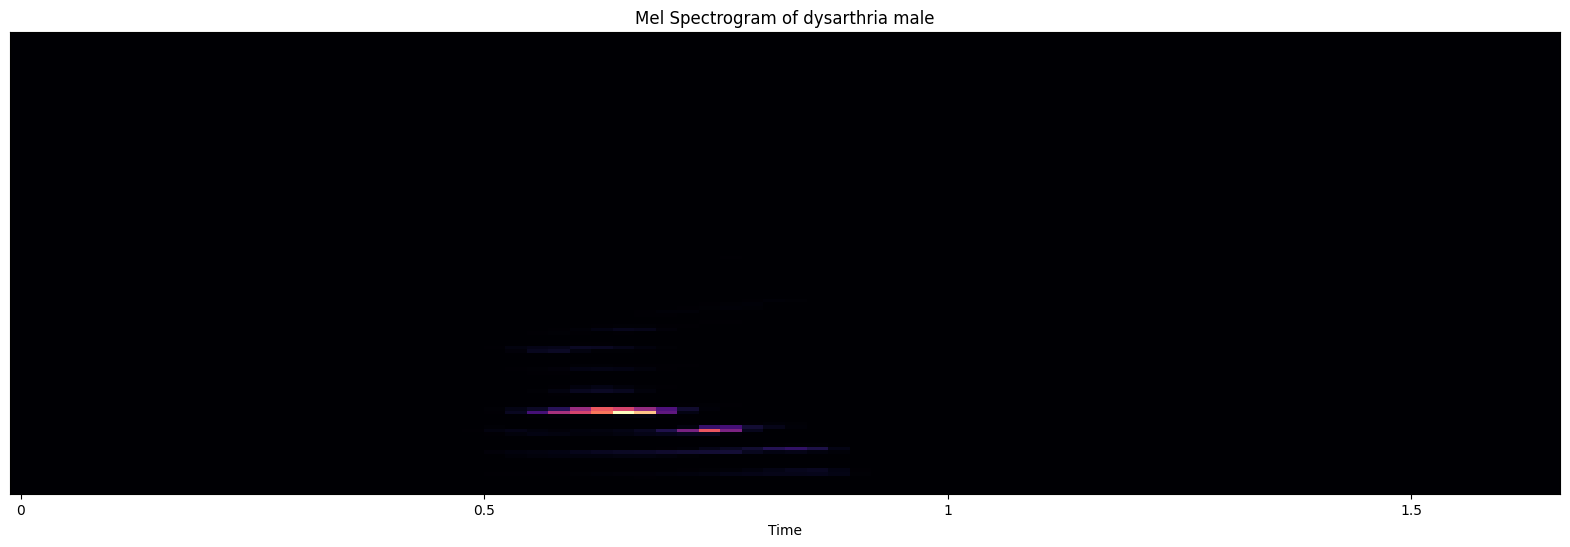

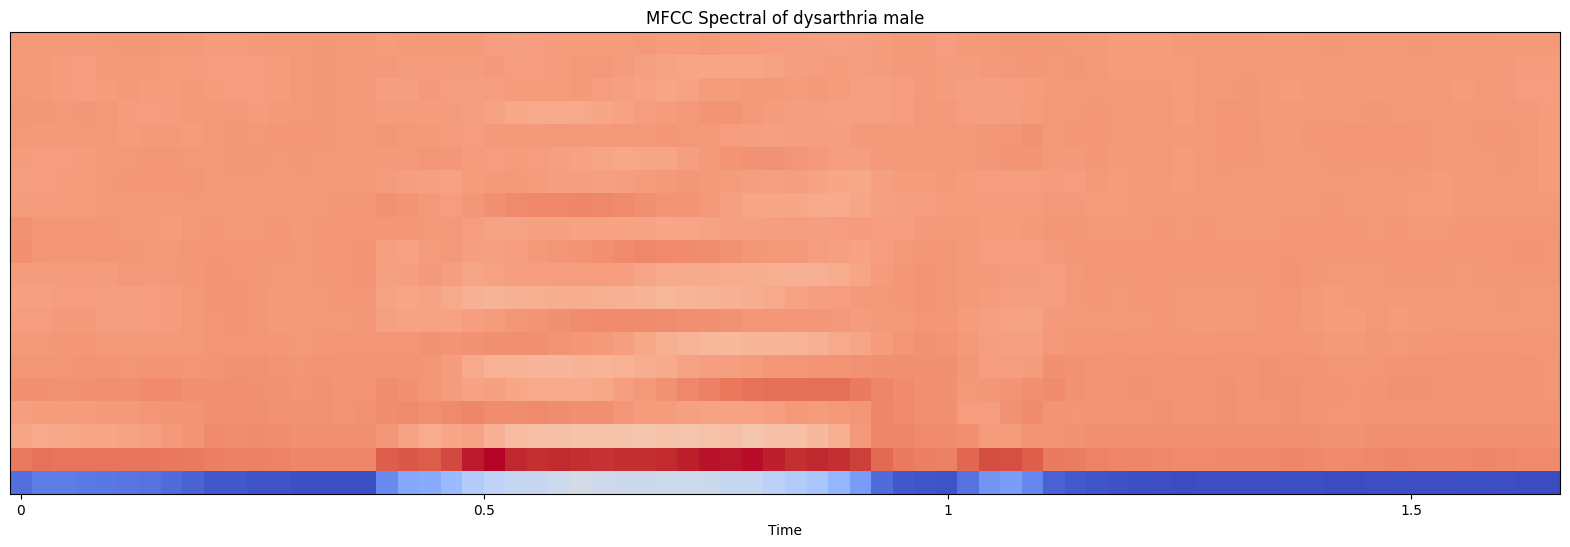

In [51]:
sample_male_dysarthria = df[(df["is_dysarthria"] == "dysarthria") & (df["gender"] == "male")]
get_feature_plot(sample_male_dysarthria['filename'].values[0],
                 sample_male_dysarthria['is_dysarthria'].values[0],
                 sample_male_dysarthria['gender'].values[0])
ipd.Audio(sample_male_dysarthria.filename.values[0])

In [53]:
df.sample(frac=1).reset_index(drop=True,inplace=True)
male_dysarthric = df[(df['gender']=='male') & (df['is_dysarthria']=='dysarthria')].sample(1)
female_dysarthric = df[(df['gender']=='female') & (df['is_dysarthria']=='dysarthria')].sample(1)
male_ndysarthric = df[(df['gender']=='male') & (df['is_dysarthria']=='non_dysarthria')].sample(1)
female_ndysarthric = df[(df['gender']=='female') & (df['is_dysarthria']=='non_dysarthria')].sample(1)

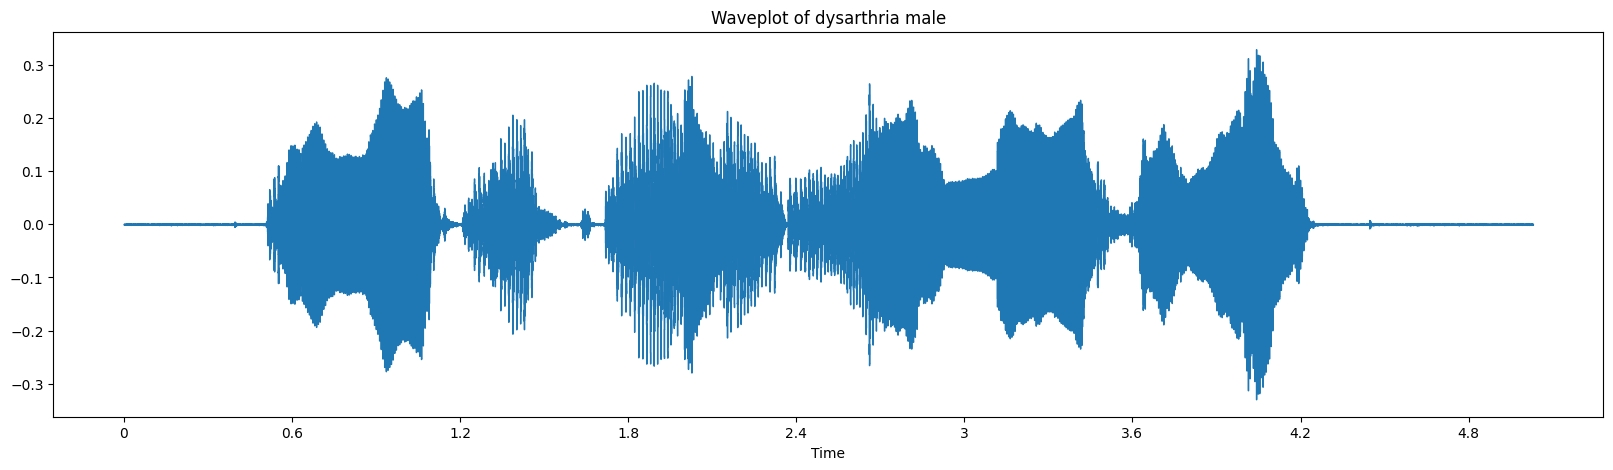

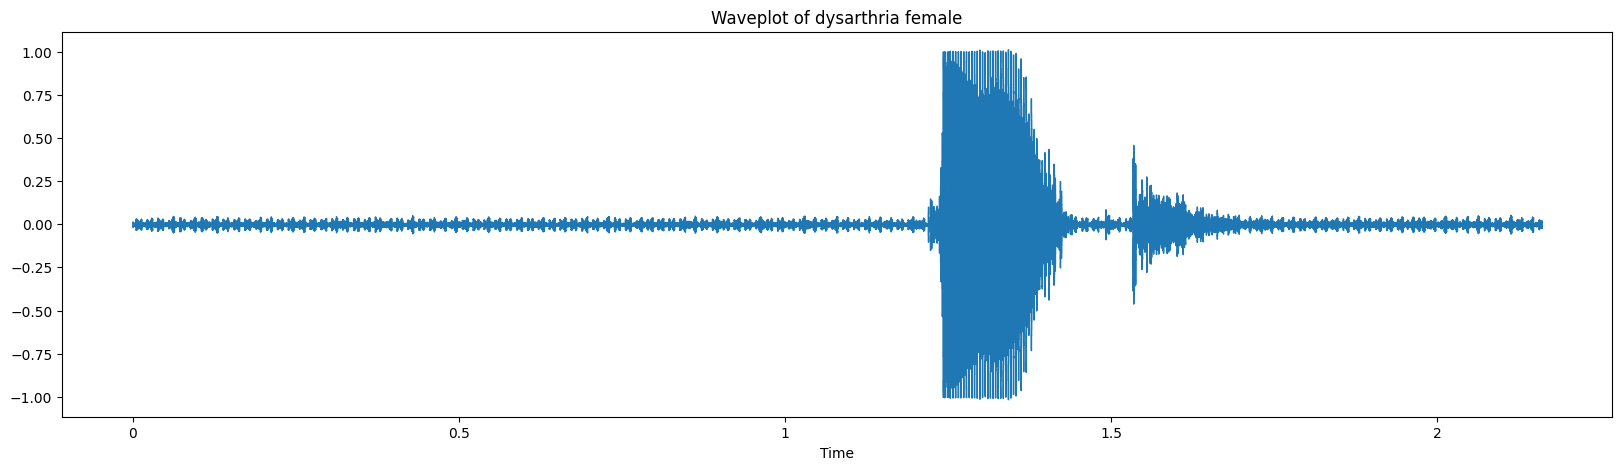

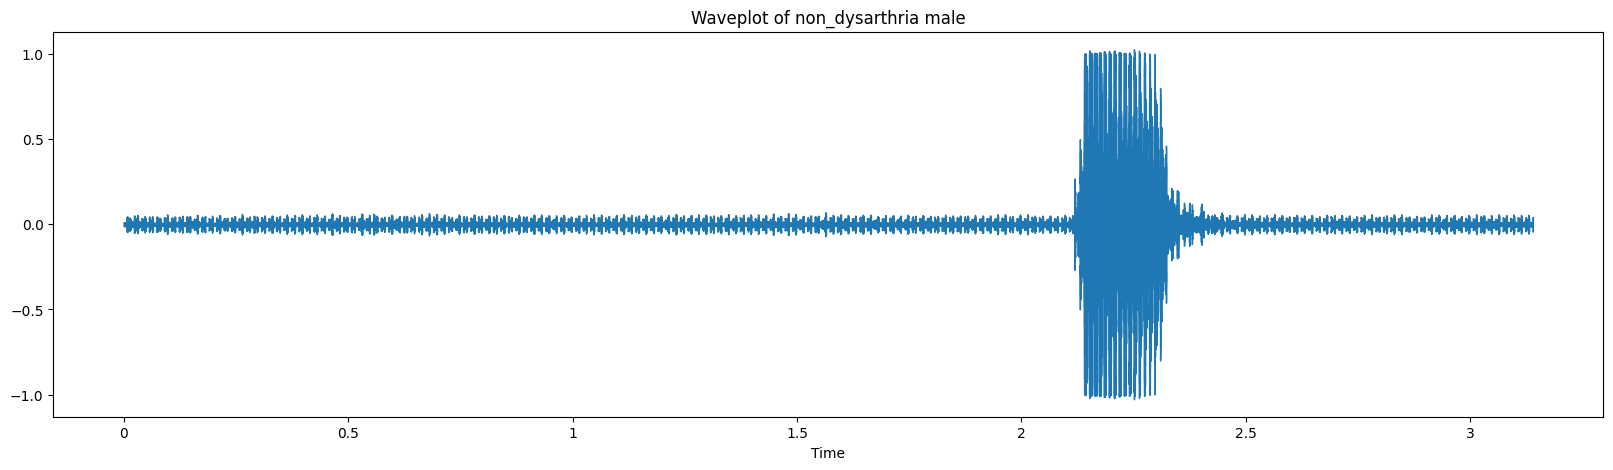

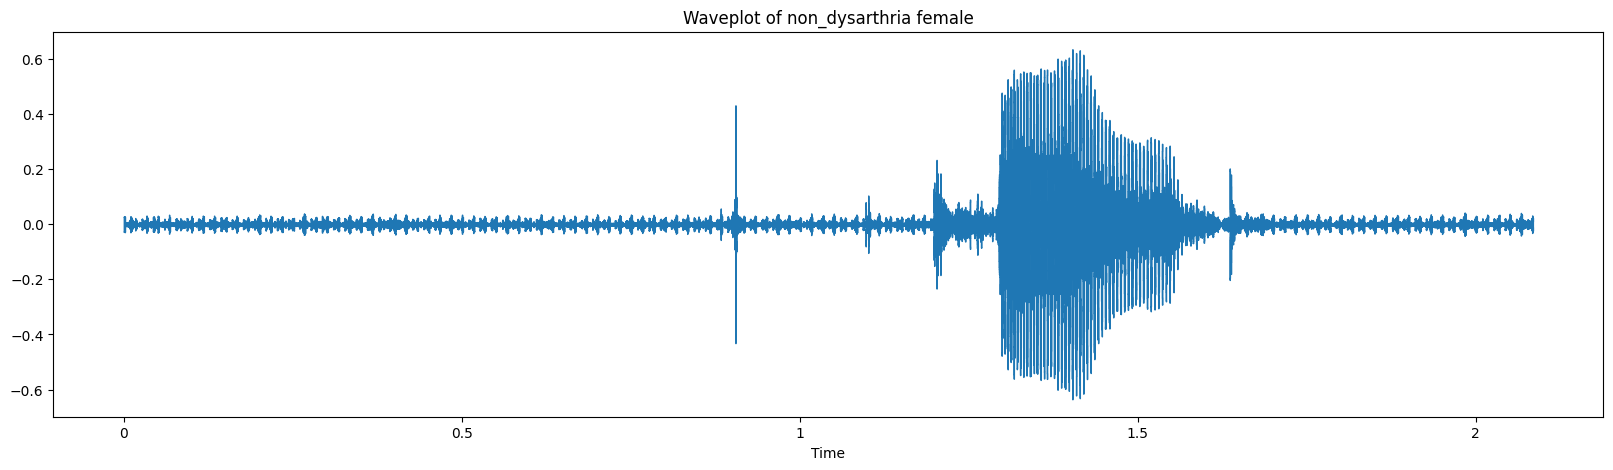

In [55]:
waveform(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
waveform(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
waveform(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
waveform(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

### Dysarthric male:
- The speech sounds slurred, which can be seen in the irregular waveplot. This happens because dysarthria affects motor control, making speech less clear and harder to follow.
### Dysarthric female :
- The speech is fast and difficult to understand, as indicated by the box-like patterns in the waveplot. The overlapping words in the waveplot reflect how dysarthria can cause speech to be rapid and unclear, disrupting normal speech rhythm.
### Non-dysarthric :
- The speech has a regular pace, which is reflected in the smooth, consistent waveplot. This regular pattern indicates normal speech, where each word and syllable is distinct and the rhythm is stable.

# Spectogram

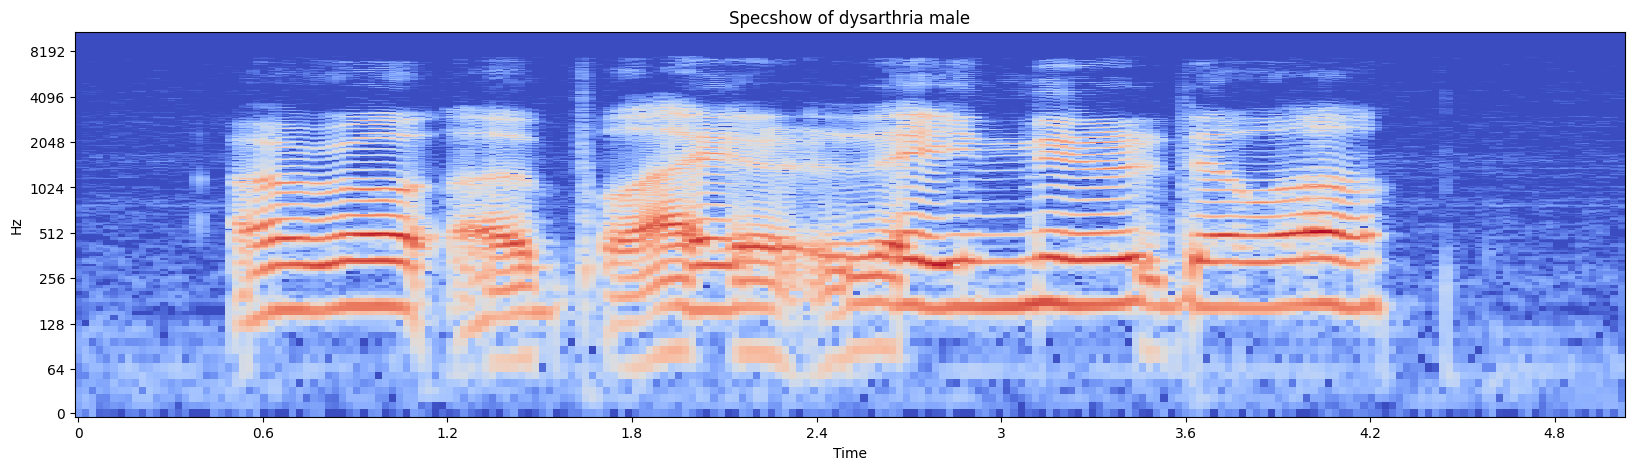

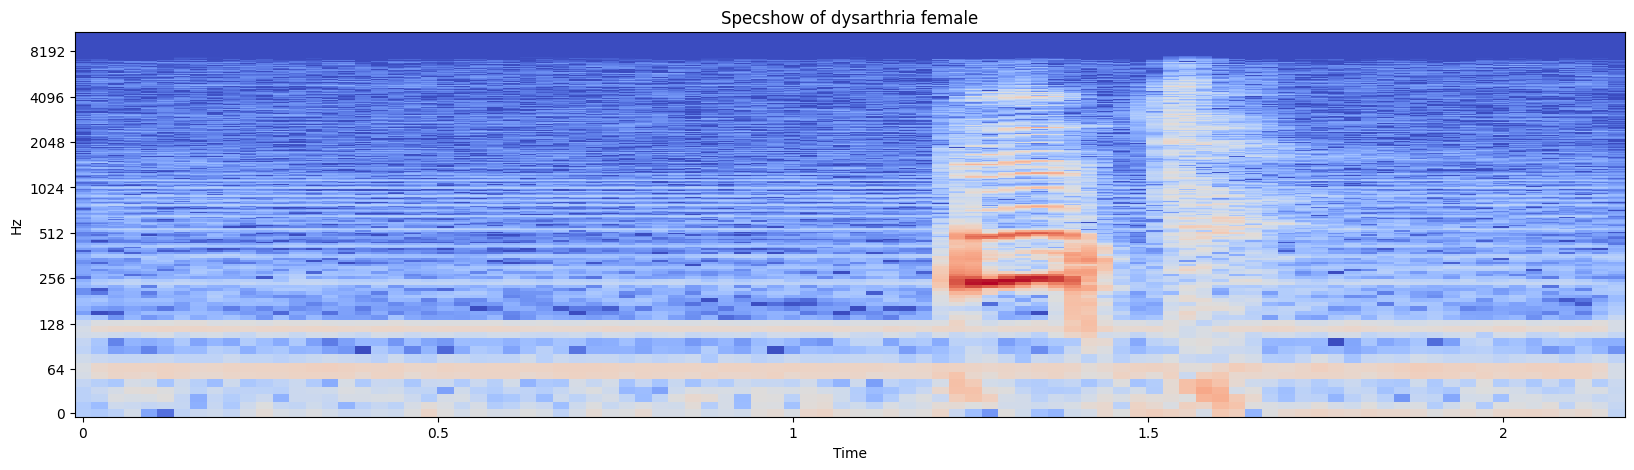

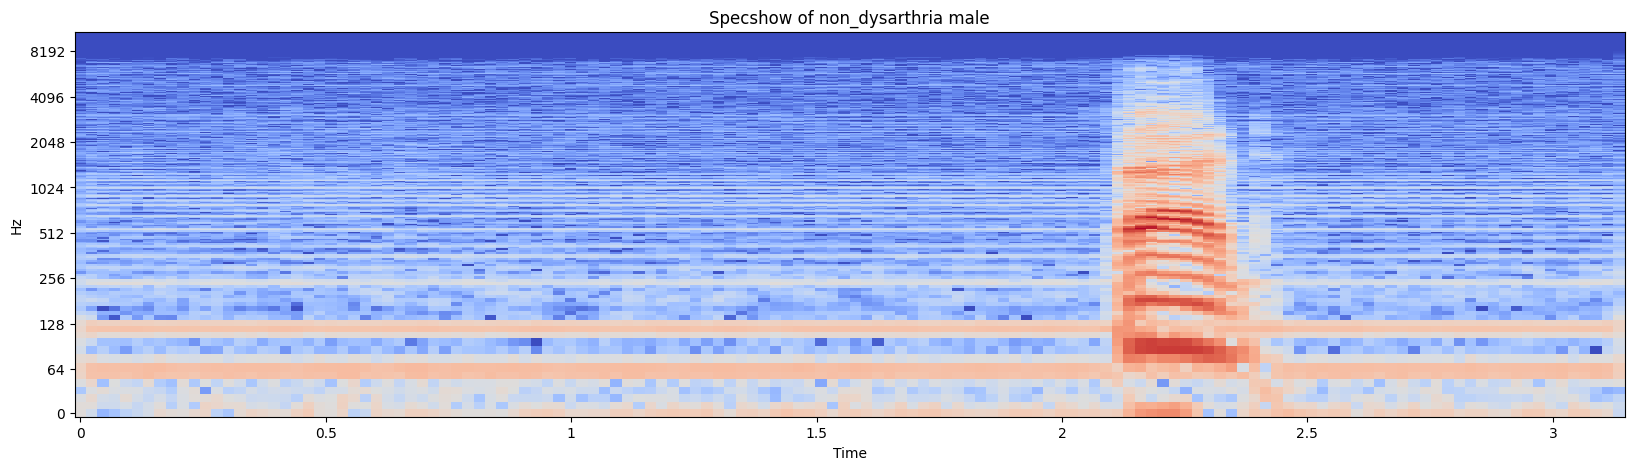

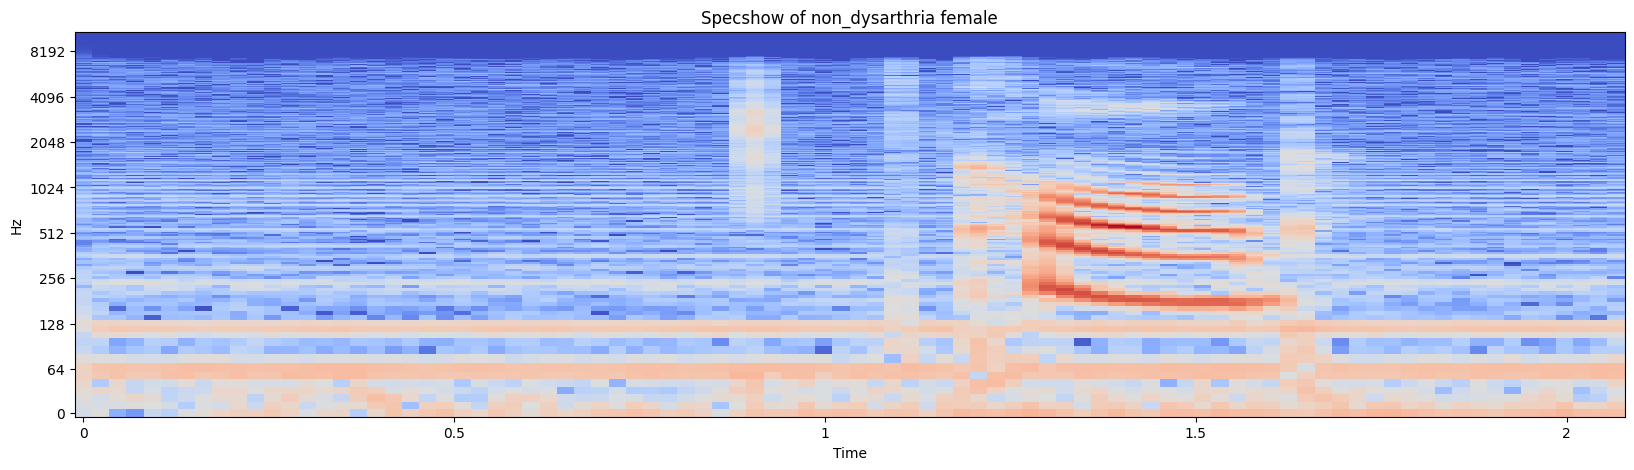

In [56]:
Spectogram(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
Spectogram(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
Spectogram(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
Spectogram(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

### Dysarthric :
- The energy magnitudes of frequencies are more spread out across time, which shows slow or slurred speech. This could also happen when words are spoken rapidly and overlap, or in cases where a person with dysarthria speaks in a monotonous manner.
### Non-dysarthric :
- The energy magnitudes are more focused on the parts where speech occurs, showing a regular pace of speaking. This pattern reflects normal speech, where the energy is concentrated when a person speaks, without the irregularities seen in dysarthria.

## Zero Crossing Rate

Sum of zero crossing  6446


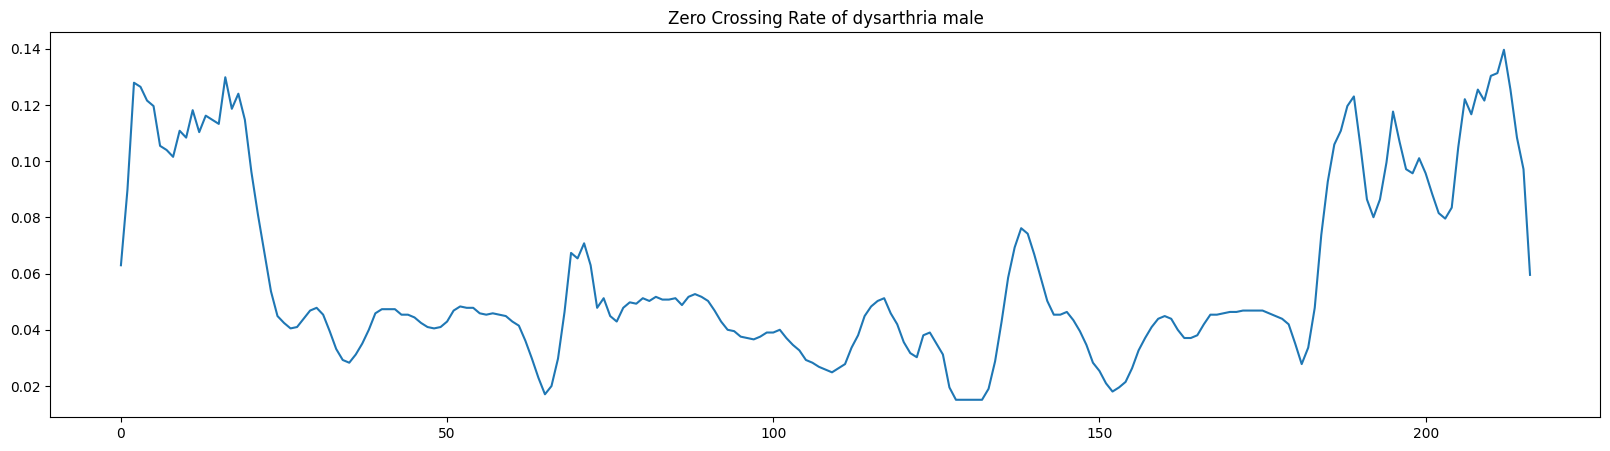

Sum of zero crossing  4121


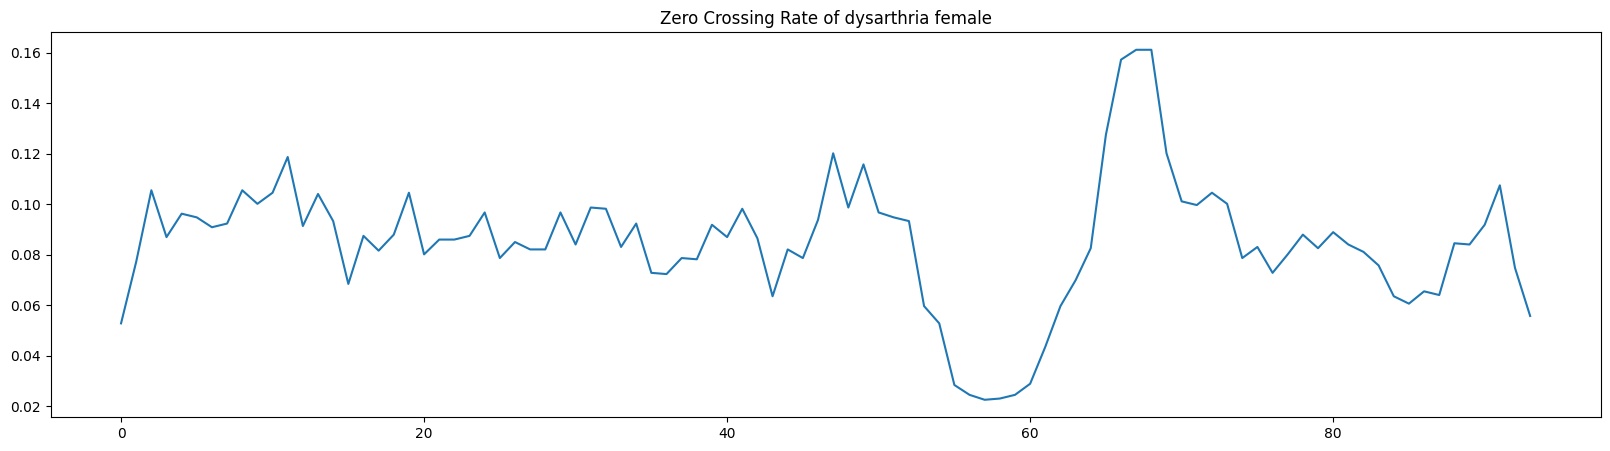

Sum of zero crossing  4514


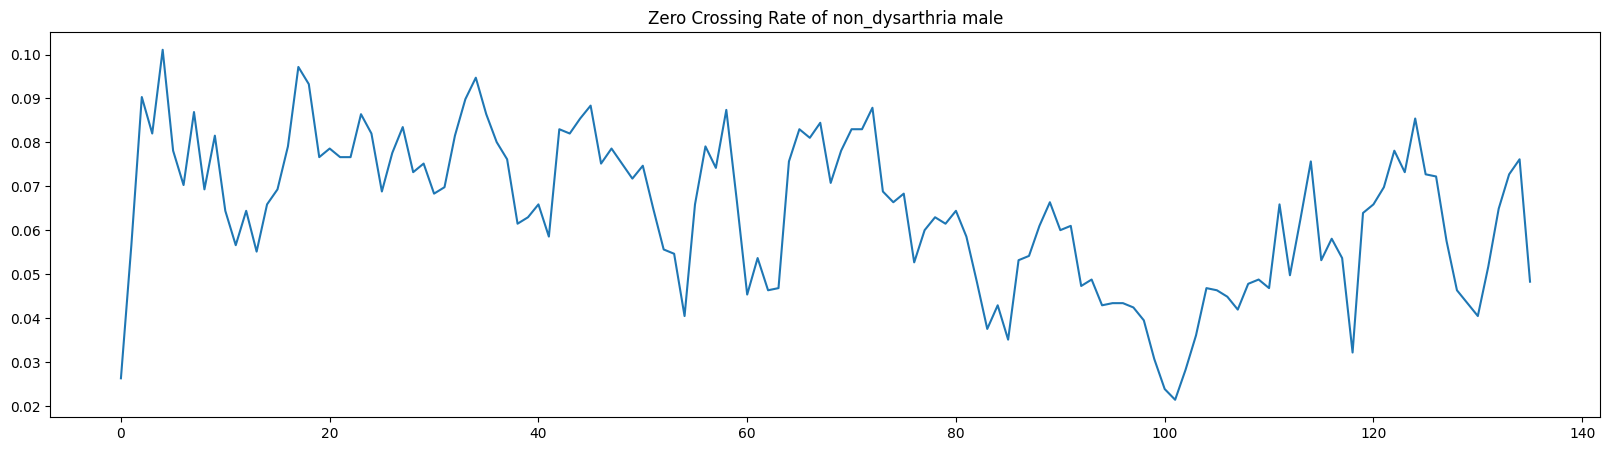

Sum of zero crossing  3176


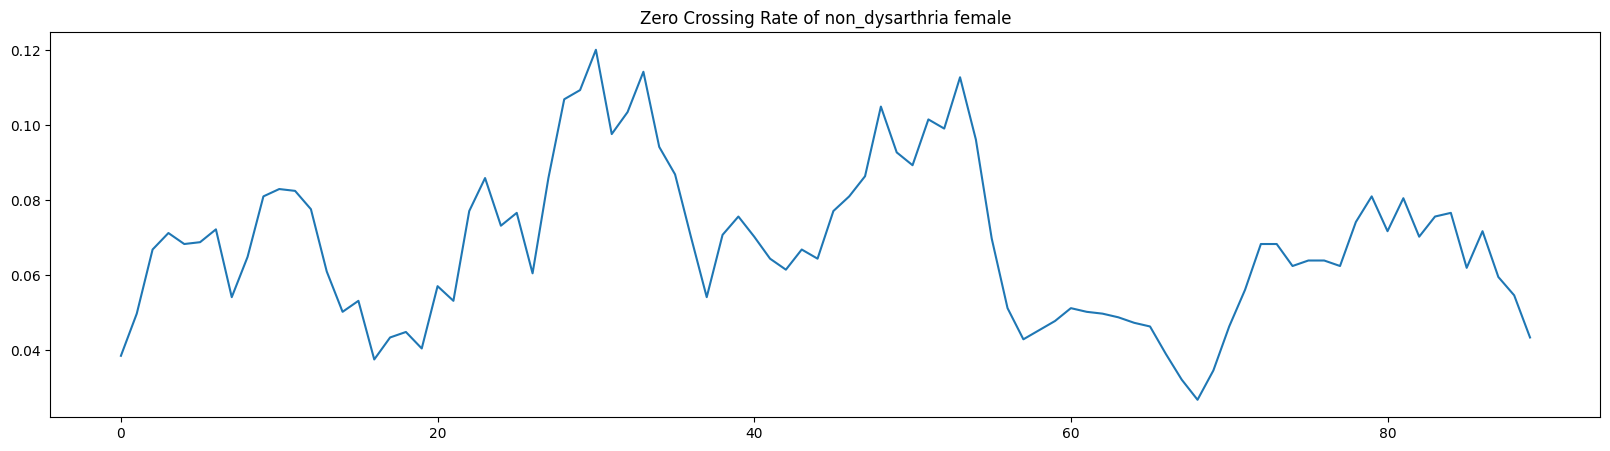

In [57]:
Zero_crossing_rate(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
Zero_crossing_rate(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
Zero_crossing_rate(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
Zero_crossing_rate(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

### Dysarthric :
- In the audio, there are instances where certain words or sentences are louder (e.g., in the female dysarthric case), causing multiple peaks in the zero-crossing rate.
These sudden increases in loudness may occur because the person has less control over their tongue and mouth muscles, making it difficult to stress words intentionally.
### Non-dysarthric samples:
- The zero-crossing rate is higher during the times when the speaker's voice is clearly audible, reflecting a more consistent and natural rhythm in their speech.

## MFCC

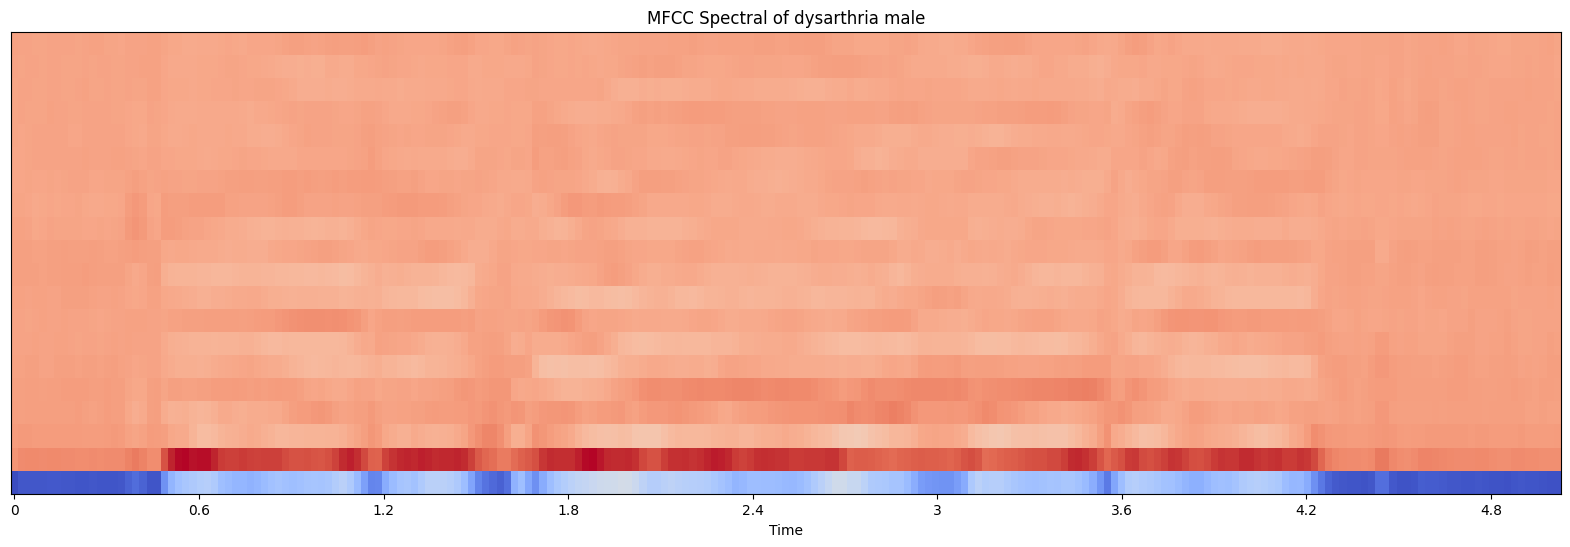

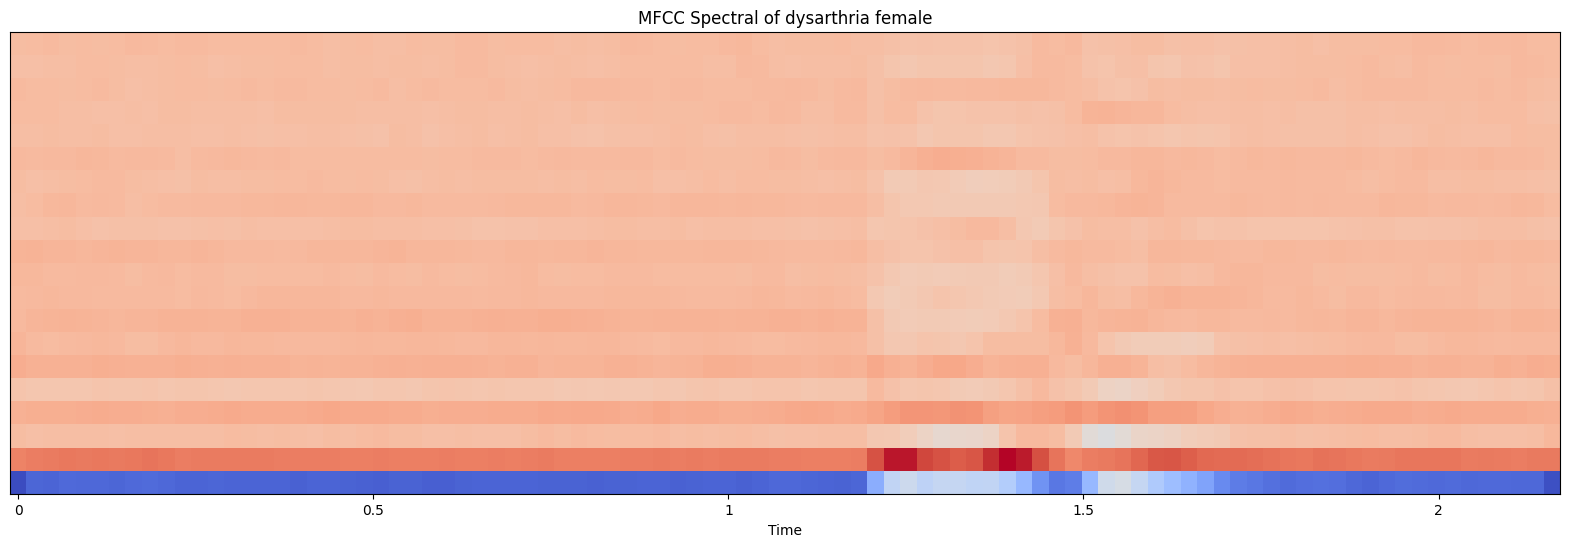

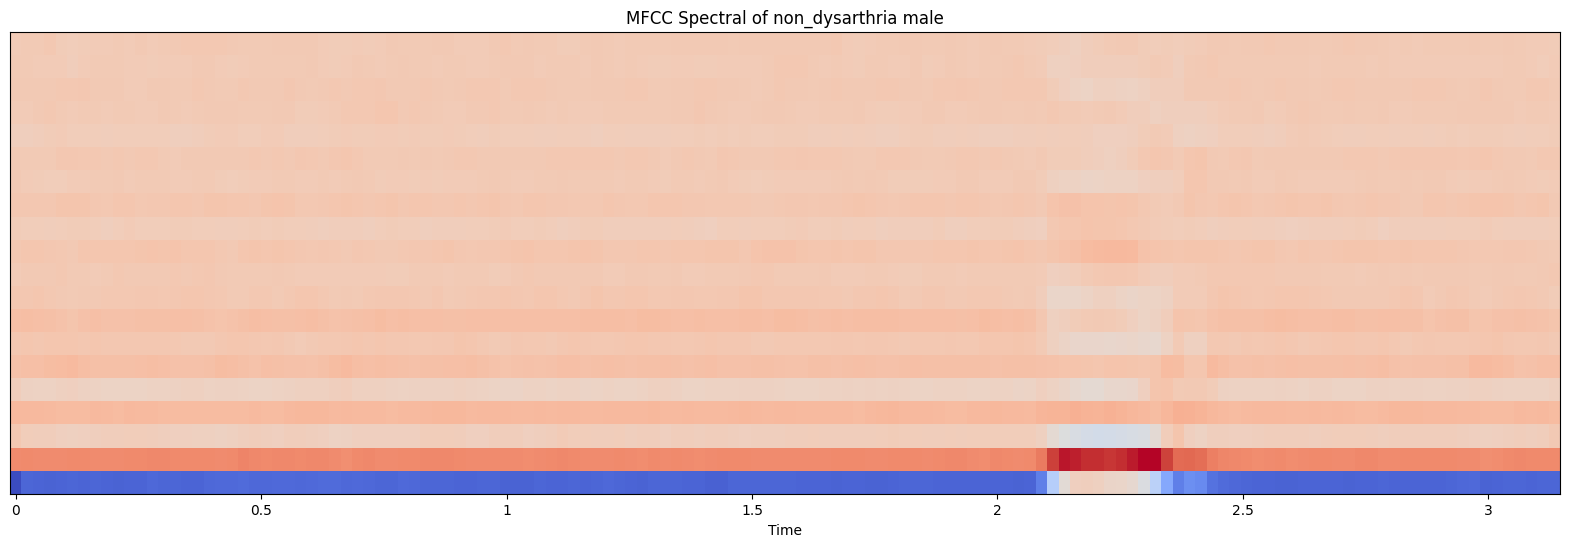

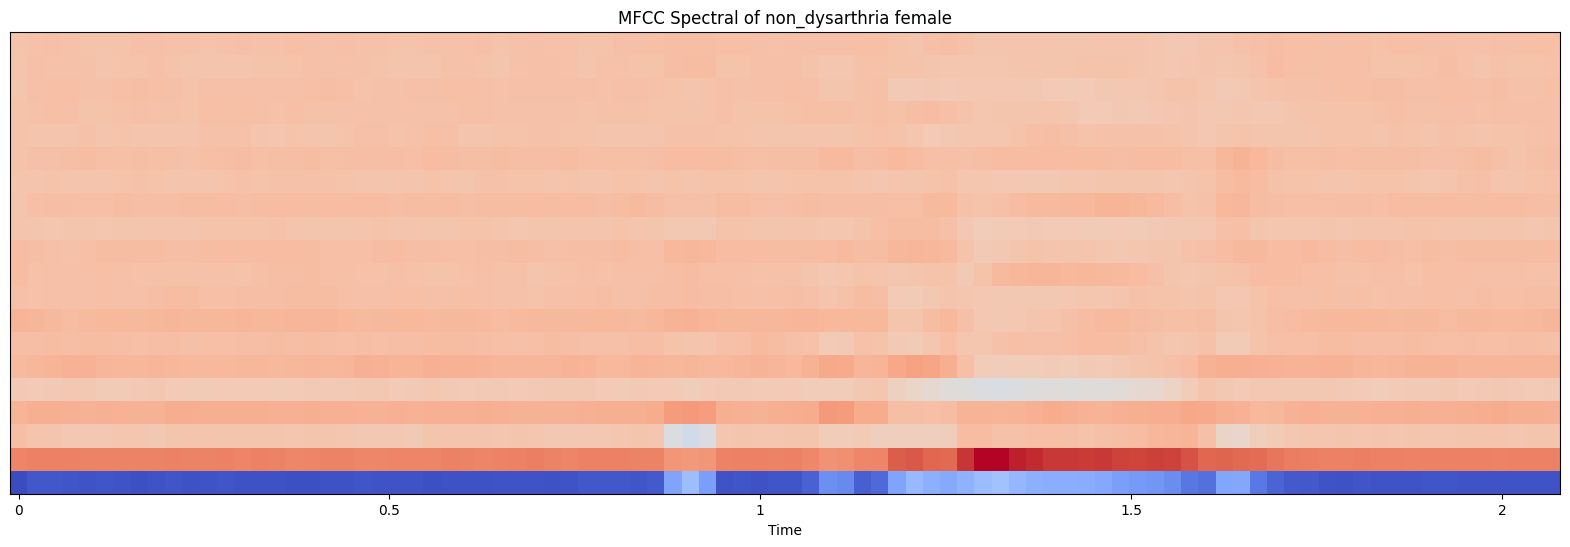

In [58]:
mfcc(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
mfcc(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
mfcc(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
mfcc(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

### Dysarthric :
The MFCC (Mel-frequency cepstral coefficients) visualization shows darker and more concentrated pixels, which reflect the slurred speech characteristic of dysarthria.
The concentration of these pixels indicates irregularities in speech, such as unclear pronunciation and difficulty with articulation.
### Non-dysarthric :
The MFCC visualization is less concentrated, with the pixels being more spread out.
This indicates more clear and steady speech, as non-dysarthric speakers typically have more consistent control over their speech patterns.

# Feature extraction And Model

In [13]:
def create_mfcc_features(path):
    mfccs = []
    try:
        x , sr = librosa.load(path)
        mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128)
        mfccs = np.mean(mfccs.T,axis=0)
    except:
        print('Error reading audio')
    return mfccs

In [14]:
%%time
X_df = pd.DataFrame(df['filename'].apply(lambda x: create_mfcc_features(x)).tolist())
X_df.head()

<ipython-input-13-a4d2a6ff55ff>:4: UserWarning: PySoundFile failed. Trying audioread instead.
  x , sr = librosa.load(path)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error reading audio


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=209
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=583
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=581
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=185
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=946
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=214
  warnings.warn(


CPU times: user 27.2 s, sys: 19.2 s, total: 46.3 s
Wall time: 26 s


0           1          2          3          4          5    \
0 -221.788269  101.259232 -16.548132  38.492065 -13.595653  20.772556   
1 -299.520081  109.872574 -17.097267  38.854969 -16.881130  22.959133   
2 -302.950043  112.048477 -23.679882  44.887421 -22.434727  26.299335   
3 -210.861603  116.504486 -35.046497  37.670425 -27.112514  25.593725   
4 -280.227203  104.505035 -17.209877  45.064884 -15.542122  28.115065   

        6          7         8         9    ...       118       119       120  \
0 -5.536349  10.410690  1.962461 -0.799048  ...  1.363241  0.962193  0.744855   
1  1.824228  18.724186  3.448541  4.455821  ...  1.329316  1.105589  1.056284   
2  0.811477  18.210291  4.344697  4.912156  ...  0.993410  0.844332  0.530004   
3 -7.511986  13.140750 -0.587347  4.138087  ...  1.068848  0.630752  0.898457   
4 -3.449209  16.841436  4.573242  1.738296  ...  1.486205  1.596206  0.970084   

        121       122       123       124       125       126       127  
0  1.058080  0.388451  0.081758  0.546172  0.594357  0.170033 -0.219215  
1  1.252576  0.027333 -1.368948 -0.037859  0.020661 -0.082124 -0.744831  
2  1.018391  0.055385 -1.472088  0.295324  0.191228 -0.224301 -0.582725  
3  0.721398  0.174576 -0.090706  0.001523  0.360464 -0.075449 -0.259715  
4  0.732015  0.547593 -0.152664  0.131893 -0.288228 -0.468570 -0.461726  

[5 rows x 128 columns]

In [15]:
X = X_df
y = df['is_dysarthria']
y = y.replace({"non_dysarthria": 0,"dysarthria":1}) ## 0 represents Non dysarthria and 1 represents dysarthria

<ipython-input-15-4bda674ea928>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({"non_dysarthria": 0,"dysarthria":1}) ## 0 represents Non dysarthria and 1 represents dysarthria


In [16]:
data1 = pd.DataFrame(X_df,columns=range(0,128))
data1["class"] =y

In [17]:
data1

0           1          2          3          4          5  \
0    -221.788269  101.259232 -16.548132  38.492065 -13.595653  20.772556   
1    -299.520081  109.872574 -17.097267  38.854969 -16.881130  22.959133   
2    -302.950043  112.048477 -23.679882  44.887421 -22.434727  26.299335   
3    -210.861603  116.504486 -35.046497  37.670425 -27.112514  25.593725   
4    -280.227203  104.505035 -17.209877  45.064884 -15.542122  28.115065   
...          ...         ...        ...        ...        ...        ...   
1995 -304.231995  115.359306  -0.794746  26.543352  -0.682190  13.183387   
1996 -457.822144  110.087799  22.221983  -0.056086 -11.181323   3.190089   
1997 -371.546875  116.846909   5.667272  22.488144   8.221014   7.740132   
1998 -302.500702  112.511192  -4.506541  32.498363  -1.519380   4.109807   
1999 -385.800110   96.079292   8.155581  31.456228  -5.310201  17.052402   

             6          7         8         9  ...       119       120  \
0    -5.536349  10.410690  1.962461 -0.799048  ...  0.962193  0.744855   
1     1.824228  18.724186  3.448541  4.455821  ...  1.105589  1.056284   
2     0.811477  18.210291  4.344697  4.912156  ...  0.844332  0.530004   
3    -7.511986  13.140750 -0.587347  4.138087  ...  0.630752  0.898457   
4    -3.449209  16.841436  4.573242  1.738296  ...  1.596206  0.970084   
...        ...        ...       ...       ...  ...       ...       ...   
1995  2.389221   4.290236 -1.372811 -2.624718  ...  0.473923  0.103740   
1996 -4.499060   4.474746  5.809545 -1.913331  ...  0.622933  0.508349   
1997  8.989120   9.996635  4.383992  3.590931  ...  0.240280 -0.009779   
1998  4.611475   9.744306 -2.962905 -3.497744  ...  0.146675 -0.200982   
1999  8.346517  12.127321  3.636642  0.342048  ...  0.865302  0.567675   

           121       122       123       124       125       126       127  \
0     1.058080  0.388451  0.081758  0.546172  0.594357  0.170033 -0.219215   
1     1.252576  0.027333 -1.368948 -0.037859  0.020661 -0.082124 -0.744831   
2     1.018391  0.055385 -1.472088  0.295324  0.191228 -0.224301 -0.582725   
3     0.721398  0.174576 -0.090706  0.001523  0.360464 -0.075449 -0.259715   
4     0.732015  0.547593 -0.152664  0.131893 -0.288228 -0.468570 -0.461726   
...        ...       ...       ...       ...       ...       ...       ...   
1995  0.311737  0.015566 -0.055351  0.193023  0.332826  0.014455 -0.221991   
1996  0.398737  0.455839  0.348571  0.286893  0.150862 -0.052999  0.001199   
1997 -0.018253 -0.014393 -0.263360  0.556257  0.749682 -0.283888 -0.398581   
1998  0.388719  0.160434 -0.383473  0.417755  1.042827 -0.082762 -0.111990   
1999  0.632113  0.017563 -0.279237  0.666378  0.482809 -0.240434 -0.301907   

      class  
0         0  
1         0  
2         0  
3         0  
4         0  
...     ...  
1995      1  
1996      1  
1997      1  
1998      1  
1999      1  

[2000 rows x 129 columns]

In [18]:
data1.isna().sum().sum()


128

In [19]:
data1 = data1.dropna()

In [20]:
X = data1.iloc[:,:-1]
y = data1.iloc[:,-1:]

In [21]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.20,stratify = y)



In [22]:
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train)
x_val_scale = scaler.transform(x_val)

In [23]:
x_train = x_train_scale.reshape(x_train.shape[0], 16, 8, 1)
x_val = x_val_scale.reshape(x_val.shape[0], 16, 8, 1)

## Model Architecture

This architecture employs efficient design choices that strike a balance between computational efficiency and performance. The use of convolutional layers enables the model to learn hierarchical features, while the max pooling layers simplify the features and improve generalization. The dense layers at the end allow for powerful decision-making based on the learned features.

In [36]:
import tensorflow as tf

tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(16, 8, 1)),  # Input shape remains
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding="same"),  # Reduced filters
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding="same"),  # Reduced filters
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation='relu'),  # Reduced Dense layer size
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 16, 8, 8)            │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 8, 4, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 4, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 2, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,193 (4.66 KB)

 Trainable params: 1,193 (4.66 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy', metrics=['accuracy']) #metrics was changed to a list

In [26]:
model.save("model.keras")  # Saves the entire model (architecture + weights + optimizer state)


In [34]:
import pickle
with open('/content/my_model.pkl', 'wb') as f:
    pickle.dump(model, f)
    print("Model saved as my_model.pkl")


Model saved as my_model.pkl


In [35]:
# Save the model using pickle
with open('/content/my_keras_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved as my_keras_model.pkl")

Model saved as my_keras_model.pkl


In [38]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(x_train, y_train, epochs=100,validation_data=(x_val,y_val),
                    callbacks=[callback])

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.6442 - loss: 0.6373 - val_accuracy: 0.7775 - val_loss: 0.4957
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7919 - loss: 0.4603 - val_accuracy: 0.8125 - val_loss: 0.3946
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8565 - loss: 0.3631 - val_accuracy: 0.8650 - val_loss: 0.3261
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8757 - loss: 0.2983 - val_accuracy: 0.8900 - val_loss: 0.2669
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9001 - loss: 0.2625 - val_accuracy: 0.9200 - val_loss: 0.2221
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9188 - loss: 0.2245 - val_accuracy: 0.9275 - val_loss: 0.1968
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9256 - loss: 0.1950 - val_accuracy: 0.9275 - val_loss: 0.1834
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9399 - loss: 0.1679 - val_accuracy: 0.9300 - 

## Conclusion:
- The model achieved a validation accuracy of 96.75% by Epoch 25, demonstrating its strong generalization ability. The validation loss decreased and stabilized, indicating effective learning without overfitting.

## Proof of No Overfitting:

- The validation accuracy and training accuracy improved steadily without significant divergence.
- The validation loss decreased and plateaued, showing the model is not memorizing the training data.
- There was no significant gap between training and validation accuracy, and validation loss remained consistent, confirming the model's balanced performance.

# Evaluation

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
training accuracy =  99.68730456535334


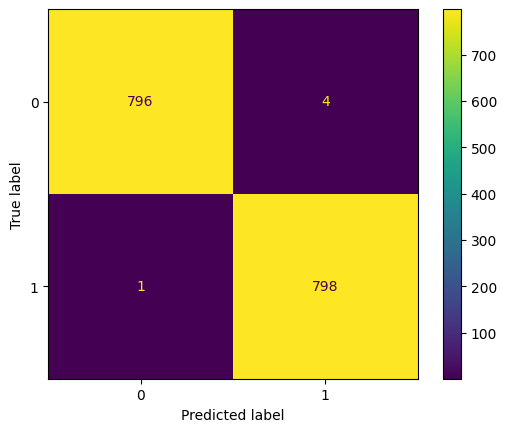

testing accuracy =  96.75


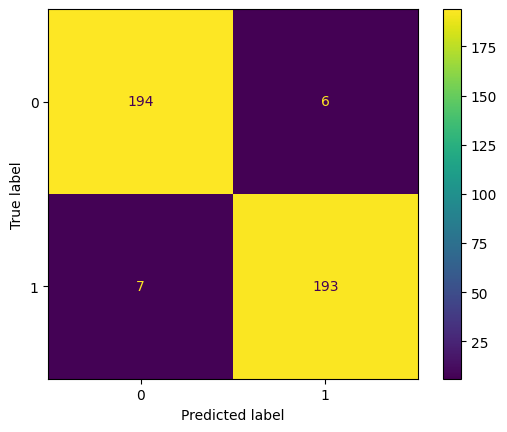

In [39]:
y_train_pred = np.where(model.predict(x_train) > 0.5, 1,0)
y_test_pred = np.where(model.predict(x_val) > 0.5, 1,0)
print("training accuracy = ",accuracy_score(y_train,y_train_pred)*100)
ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred)
plt.show()
print("testing accuracy = ",accuracy_score(y_val,y_test_pred)*100)
ConfusionMatrixDisplay.from_predictions(y_val,y_test_pred)
plt.show()

In [40]:
from sklearn.metrics import roc_auc_score,classification_report
print("train Roc_auc score = ", roc_auc_score(y_train,y_train_pred))
print("test Roc_auc score = ", roc_auc_score(y_val,y_test_pred))

train Roc_auc score =  0.9968742177722153
test Roc_auc score =  0.9674999999999999


## Conclusion
The model demonstrates exceptional performance, as reflected by the ROC-AUC scores of 0.9969 on the training set and 0.9675 on the test set. The high test ROC-AUC score indicates that the model generalizes well to unseen data, effectively distinguishing between classes. Additionally, the minimal gap between the training and test scores suggests that overfitting has not occurred, ensuring reliable performance in real-world applications.